### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000019DB2B35E50>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 8: ESR data preparation

***

## Import modules

In [2]:
import librosa
import librosa.display
import os
import warnings
import random
import sklearn
import itertools
import mimetypes
import time
import pickle
import sys

import pandas     as pd
import seaborn    as sns
import tensorflow as tf
import numpy      as np
import IPython.display as ipd


from matplotlib  import pyplot  as plt
from keras       import backend as K


from tqdm                        import tqdm
from collections                 import Counter

from sklearn                     import metrics
from sklearn.model_selection     import StratifiedKFold, StratifiedShuffleSplit, KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics             import confusion_matrix, classification_report
from sklearn.feature_selection   import mutual_info_classif, SelectKBest, chi2

from tensorflow                  import keras
from tensorflow.keras.models     import Sequential, load_model
from tensorflow.keras.layers     import Dense, Dropout, Flatten, InputLayer, Conv2D
from tensorflow.keras.layers     import MaxPooling2D, BatchNormalization, Activation

from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks             import ModelCheckpoint, EarlyStopping
from keras.optimizers            import SGD
from keras.constraints           import maxnorm

from scipy.stats                 import skew, kurtosis

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

FRAME_SIZE = 1024
HOP_LENGTH = 512
SEED       = 1000
SR         = 22050

tf.random.set_seed(SEED)
np.random.seed(SEED)

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

## Data preparation

In [3]:
cmap_cm     = plt.cm.Blues

path        = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\US8K_AV\\"
path_models = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\96_code_cv\\ESR\\Saved_models_fold_1_validation\\"
path_arrays = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\96_code_cv\\ESR\\Arrays\\"

nom_dataset               = 'US8K_AV' 
csv_file                  = 'US8K_AV.csv'
fold_name                 = '01'

pkl_features              = 'US8K_AV_features_original.pkl'
pkl_aug_wind_features     = 'US8K_AV_features_windowed.pkl' # not augmented, just windowed
pkl_aug_features          = 'US8K_AV_features_augmented_no_windowing.pkl'

pkl_aug_wind_features_CNN = 'US8K_AV_features_aug_wind_CNN_2D.pkl'

DB_ori_from_pkl       = pd.read_pickle(path + pkl_features)
DB_aug_from_pkl       = pd.read_pickle(path + pkl_aug_wind_features)
DB_aug_CNN2D_from_pkl = pd.read_pickle(path + pkl_aug_wind_features_CNN)

In [4]:
print(type(DB_ori_from_pkl['Fold'][0][0]))
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'str'>
<class 'int'>
<class 'list'>
<class 'int'>
<class 'list'>


In [5]:
print(type(DB_aug_CNN2D_from_pkl['fold'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['fold'][0]))
print(type(DB_aug_CNN2D_from_pkl['label'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['label'][0]))
print(type(DB_aug_CNN2D_from_pkl['label'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['label'][0]))

<class 'str'>
<class 'str'>
<class 'int'>
<class 'list'>
<class 'int'>
<class 'list'>


In [6]:
DB_ori_from_pkl

Audio Class_categorical       Class_OHEV Fold  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
0     [-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...          dog_bark  [0, 0, 0, 1, 0]   05  ...       0.024244         -0.049756        0.759231           -0.024962
1     [0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...  children_playing  [0, 0, 1, 0, 0]   05  ...       0.018670         -0.018241        0.275013           -0.497943
2     [-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...  children_playing  [0, 0, 1, 0, 0]   05  ...       0.018733          0.009139       -0.205466           -0.212879
3     [0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...  children_playing  [0, 0, 1, 0, 0]   05  ...       0.027117          0.007208       -0.769827            0.623153
4     [0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...  children_playing  [0, 0, 1, 0, 0]   05  ...       0.025776          0.050245        0.208739           -1.062755
...                                                                                                                       ...               ...              ...  ...  ...            ...               ...             ...                 ...
4353  [-0.00048753922, -0.0029013595, -0.0060868477, -0.0077148406, -0.008069417, -0.008534078, -0.008617738, -0.007554673...          car_horn  [0, 1, 0, 0, 0]   07  ...       0.022642          0.008688        0.097807           -0.866208
4354  [0.0018769287, 0.0028417986, 0.0028369268, 0.003081231, 0.0018484257, 0.0010519021, 0.00044334529, 0.0001646977, -3....          car_horn  [0, 1, 0, 0, 0]   07  ...       0.029405          0.020661       -0.220407            1.997790
4355  [-0.013202029, -0.020061549, -0.016201336, -0.014081302, -0.0110550765, -0.010160886, -0.012472121, -0.013130652, -0...          car_horn  [0, 1, 0, 0, 0]   07  ...       0.034195         -0.002075        0.725307           -0.462707
4356  [0.0008518654, -0.003709917, -0.009393071, -0.009993944, -0.0063429633, -0.0011706308, 0.0025487966, 0.0038857076, 0...          car_horn  [0, 1, 0, 0, 0]   07  ...       0.029228         -0.005832       -0.330073           -0.796058
4357  [0.013747855, 0.02544903, 0.0232341, 0.021941995, 0.016953938, 0.015256381, 0.010364529, 0.0087095965, 0.0065224236,...          car_horn  [0, 1, 0, 0, 0]   07  ...       0.044838         -0.027446       -0.471829           -0.869921

[4358 rows x 379 columns]

In [7]:
DB_aug_CNN2D_from_pkl

features            label label_cat fold
0      [[[-44.0467643737793], [-39.25644302368164], [-38.62413787841797], [-36.58848571777344], [-32.5598030090332], [-31.4...  [0, 0, 0, 1, 0]  dog_bark   05
1      [[[-29.934663772583008], [-34.787696838378906], [-40.06871795654297], [-41.22150802612305], [-41.03109359741211], [-...  [0, 0, 0, 1, 0]  dog_bark   05
2      [[[-23.2158260345459], [-28.396337509155273], [-32.66521072387695], [-31.442462921142578], [-35.61741256713867], [-3...  [0, 0, 0, 1, 0]  dog_bark   05
3      [[[-37.06025695800781], [-39.86629104614258], [-41.0966682434082], [-38.97296142578125], [-41.87018966674805], [-39....  [0, 0, 0, 1, 0]  dog_bark   05
4      [[[-28.527423858642578], [-29.930322647094727], [-35.48342514038086], [-38.032806396484375], [-38.82895278930664], [...  [0, 0, 0, 1, 0]  dog_bark   05
...                                                                                                                        ...              ...       ...  ...
30501  [[[-16.7570743560791], [-12.688139915466309], [-16.03248405456543], [-15.612970352172852], [-12.660606384277344], [-...  [0, 1, 0, 0, 0]  car_horn   07
30502  [[[-14.313464164733887], [-12.228155136108398], [-15.787863731384277], [-16.082149505615234], [-12.465015411376953],...  [0, 1, 0, 0, 0]  car_horn   07
30503  [[[-24.34674835205078], [-17.664506912231445], [-11.443778038024902], [-11.371871948242188], [-12.617921829223633], ...  [0, 1, 0, 0, 0]  car_horn   07
30504  [[[-20.291765213012695], [-13.778326034545898], [-9.759299278259277], [-8.09199333190918], [-8.728732109069824], [-1...  [0, 1, 0, 0, 0]  car_horn   07
30505  [[[-16.410991668701172], [-11.63617992401123], [-9.72879409790039], [-13.295160293579102], [-12.994491577148438], [-...  [0, 1, 0, 0, 0]  car_horn   07

[30506 rows x 4 columns]

In [8]:
for fold in np.unique(DB_aug_CNN2D_from_pkl['fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['fold'] == fold])
    trnsize = len(DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete size: {trnsize}')
    print()

Validation fold: 01
dbComplete_VAL size: 2968
dbComplete size: 27538

Validation fold: 02
dbComplete_VAL size: 3024
dbComplete size: 27482

Validation fold: 03
dbComplete_VAL size: 3255
dbComplete size: 27251

Validation fold: 04
dbComplete_VAL size: 3766
dbComplete size: 26740

Validation fold: 05
dbComplete_VAL size: 3332
dbComplete size: 27174

Validation fold: 06
dbComplete_VAL size: 2716
dbComplete size: 27790

Validation fold: 07
dbComplete_VAL size: 2814
dbComplete size: 27692

Validation fold: 08
dbComplete_VAL size: 2835
dbComplete size: 27671

Validation fold: 09
dbComplete_VAL size: 2877
dbComplete size: 27629

Validation fold: 10
dbComplete_VAL size: 2919
dbComplete size: 27587



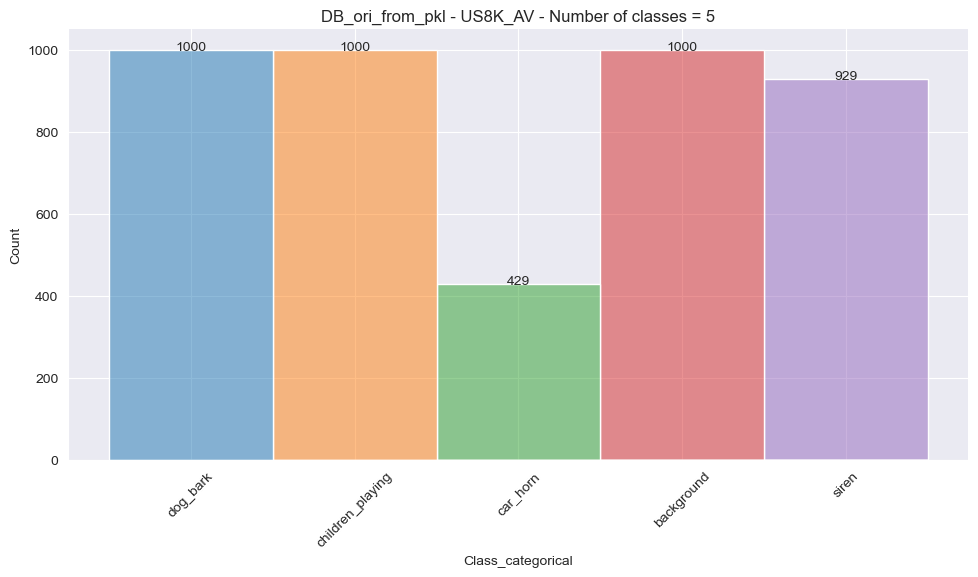

In [9]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_ori_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

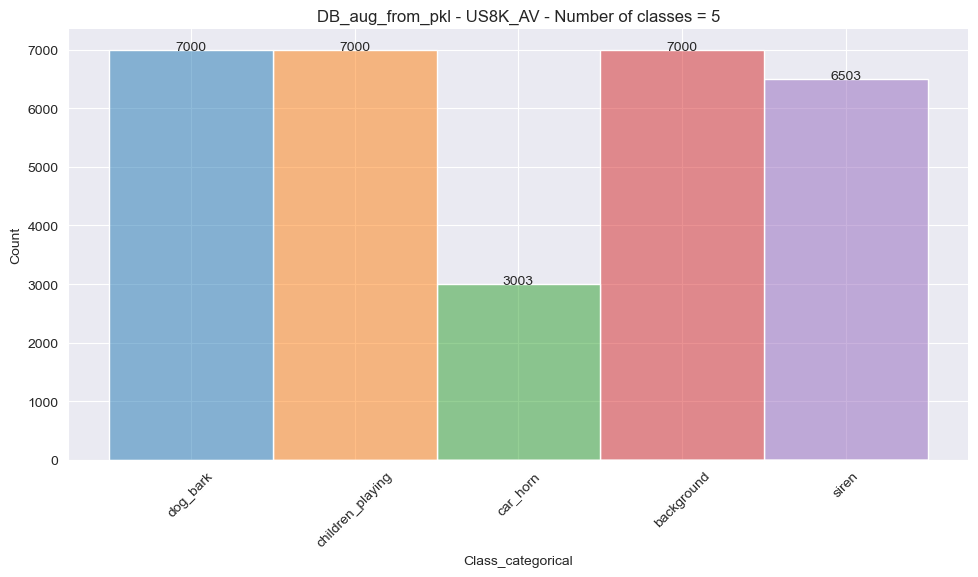

In [10]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_aug_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

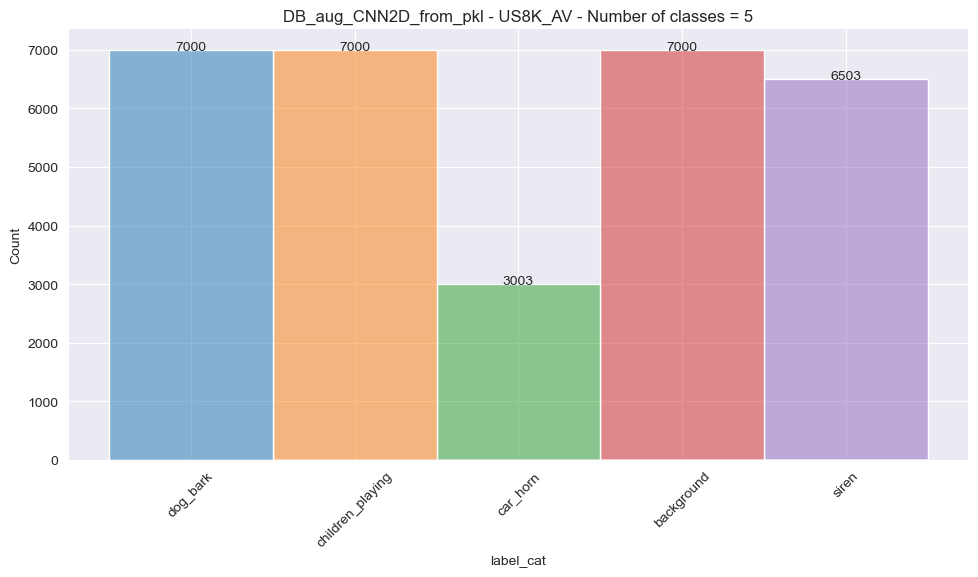

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_aug_CNN2D_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_aug_CNN2D_from_pkl['label_cat']).unique()))
g = sns.displot(DB_aug_CNN2D_from_pkl,x='label_cat', hue='label_cat',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

In [12]:
# Group by the class and get one random sample of each class
k = DB_aug_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         20959    [1, 0, 0, 0, 0]
car_horn           26787    [0, 1, 0, 0, 0]
children_playing   803      [0, 0, 1, 0, 0]
dog_bark           28046    [0, 0, 0, 1, 0]
siren              3111     [0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': [1, 0, 0, 0, 0],
 'car_horn': [0, 1, 0, 0, 0],
 'children_playing': [0, 0, 1, 0, 0],
 'dog_bark': [0, 0, 0, 1, 0],
 'siren': [0, 0, 0, 0, 1]}

In [13]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

5

In [14]:
# Name of the classes

nom_classes = list(encoder_dict.keys())

with open(path_arrays + 'nom_classes.csv', 'w') as file:
    for value in nom_classes:
        file.write(value + '\n')

nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

In [15]:
nom_classes = []
with open(path_arrays + 'nom_classes.csv', 'r') as file:
    for line in file:
        nom_classes.append(line.strip())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

In [16]:
for col in DB_ori_from_pkl.columns:
    print(col)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [17]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_ori_from_pkl_VAL = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold_name].copy()
DB_ori_from_pkl_TRN = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold_name].copy()

In [19]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_aug_from_pkl_VAL = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] == fold_name].copy()
DB_aug_from_pkl_TRN = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] != fold_name].copy()

In [20]:
print(len(DB_ori_from_pkl_VAL))
print(len(DB_ori_from_pkl_TRN))
print('Total: ', len(DB_ori_from_pkl_VAL) + len(DB_ori_from_pkl_TRN),'\n')
print(len(DB_aug_from_pkl_VAL))
print(len(DB_aug_from_pkl_TRN))
print('Total: ', len(DB_aug_from_pkl_VAL) + len(DB_aug_from_pkl_TRN))

424
3934
Total:  4358 

2968
27538
Total:  30506


In [21]:
X     = DB_aug_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y     = np.array(DB_aug_from_pkl_TRN.Class_OHEV.to_list())
y_cat = np.array(DB_aug_from_pkl_TRN.Class_categorical.to_list())


X_val     = DB_aug_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val     = np.array(DB_aug_from_pkl_VAL.Class_OHEV.to_list())
y_val_cat = np.array(DB_aug_from_pkl_VAL.Class_categorical.to_list())

In [22]:
type(X.at[1, 'RMSE'])

numpy.float64

In [23]:
# Select from normalization or standartization

def scaler(X: pd.DataFrame, opc:int):
    #opc = 0
    while str(opc) not in '12':
        print()
        print("1-) Normalization (Scaled from 0 to 1)")
        print("2-) Standartization (Standard deviation of 1)")

        opc = input("\nSelect the dataset: ")
        if opc.isdigit():
            opc = int(opc)
        else:
            opc = 0

    if opc == 1:
        X_norm = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    else:
        X_norm = X.apply(lambda x: (x - x.mean()) / x.std())
    
    return X_norm

In [24]:
X_norm = scaler(X, 1)

In [25]:
X_norm.describe()

RMSE           ZCR     CENTROIDS     BANDWIDTH  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
count  27538.000000  27538.000000  27538.000000  27538.000000  ...   27538.000000      27538.000000    27538.000000        27538.000000
mean       0.086562      0.170630      0.292964      0.448804  ...       0.111262          0.394446        0.562480            0.069520
std        0.092763      0.117546      0.129598      0.123559  ...       0.085955          0.067220        0.070701            0.046891
min        0.000000      0.000000      0.000000      0.000000  ...       0.000000          0.000000        0.000000            0.000000
25%        0.025421      0.098998      0.206059      0.358050  ...       0.064947          0.362145        0.519985            0.042597
50%        0.056026      0.143522      0.268149      0.438965  ...       0.088485          0.394243        0.561117            0.059211
75%        0.114751      0.198927      0.341918      0.526095  ...       0.128388          0.426903        0.602633            0.082118
max        1.000000      1.000000      1.000000      1.000000  ...       1.000000          1.000000        1.000000            1.000000

[8 rows x 375 columns]

In [26]:
X_norm = X_norm.values

In [27]:
X_val_norm = scaler(X_val, 1)

In [28]:
X_val_norm.describe()

RMSE          ZCR    CENTROIDS    BANDWIDTH  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
count  2968.000000  2968.000000  2968.000000  2968.000000  ...    2968.000000       2968.000000     2968.000000         2968.000000
mean      0.137536     0.143267     0.254765     0.448026  ...       0.150254          0.476677        0.522212            0.105080
std       0.139456     0.117841     0.156347     0.175659  ...       0.185230          0.121162        0.120214            0.076839
min       0.000000     0.000000     0.000000     0.000000  ...       0.000000          0.000000        0.000000            0.000000
25%       0.031239     0.069277     0.146521     0.319761  ...       0.059597          0.426979        0.447981            0.057494
50%       0.084954     0.126400     0.233185     0.425174  ...       0.088782          0.476209        0.522764            0.086765
75%       0.200176     0.173312     0.306746     0.567306  ...       0.146444          0.525092        0.599655            0.128364
max       1.000000     1.000000     1.000000     1.000000  ...       1.000000          1.000000        1.000000            1.000000

[8 rows x 375 columns]

In [29]:
X_val_norm = X_val_norm.values

In [30]:
X_std = scaler(X, 2)

In [31]:
X_std.describe()

RMSE           ZCR     CENTROIDS     BANDWIDTH  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
count  2.753800e+04  2.753800e+04  2.753800e+04  2.753800e+04  ...   2.753800e+04      2.753800e+04    2.753800e+04        2.753800e+04
mean   3.405899e-17  6.398961e-17 -2.889854e-17  7.843888e-17  ...   1.610061e-16     -1.935170e-18    2.296401e-17       -2.838249e-17
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  ...   1.000000e+00      1.000000e+00    1.000000e+00        1.000000e+00
min   -9.331453e-01 -1.451600e+00 -2.260557e+00 -3.632291e+00  ...  -1.294425e+00     -5.868034e+00   -7.955809e+00       -1.482606e+00
25%   -6.591012e-01 -6.093939e-01 -6.705676e-01 -7.344964e-01  ...  -5.388343e-01     -4.805327e-01   -6.010605e-01       -5.741730e-01
50%   -3.291740e-01 -2.306170e-01 -1.914758e-01 -7.962518e-02  ...  -2.649907e-01     -3.030675e-03   -1.928905e-02       -2.198682e-01
75%    3.038872e-01  2.407306e-01  3.777376e-01  6.255422e-01  ...   1.992363e-01      4.828494e-01    5.679180e-01        2.686574e-01
max    9.846985e+00  7.055692e+00  5.455613e+00  4.460984e+00  ...   1.033958e+01      9.008601e+00    6.188343e+00        1.984363e+01

[8 rows x 375 columns]

In [32]:
X_std = X_std.values

In [33]:
X_val_std = scaler(X_val, 2)

In [34]:
X_val_std.describe()

RMSE           ZCR     CENTROIDS     BANDWIDTH  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
count  2.968000e+03  2.968000e+03  2.968000e+03  2.968000e+03  ...    2968.000000       2968.000000     2968.000000        2.968000e+03
mean   5.745629e-17 -1.053365e-16 -3.830419e-17 -7.660838e-17  ...       0.000000          0.000000        0.000000       -5.745629e-17
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  ...       1.000000          1.000000        1.000000        1.000000e+00
min   -9.862270e-01 -1.215764e+00 -1.629479e+00 -2.550545e+00  ...      -0.811173         -3.934201       -4.344025       -1.367538e+00
25%   -7.622196e-01 -6.278794e-01 -6.923319e-01 -7.301927e-01  ...      -0.489425         -0.410177       -0.617490       -6.192986e-01
50%   -3.770490e-01 -1.431349e-01 -1.380266e-01 -1.300917e-01  ...      -0.331864         -0.003867        0.004594       -2.383531e-01
75%    4.491779e-01  2.549624e-01  3.324730e-01  6.790440e-01  ...      -0.020569          0.399590        0.644216        3.030243e-01
max    6.184473e+00  7.270250e+00  4.766535e+00  3.142306e+00  ...       4.587519          4.319186        3.974488        1.164672e+01

[8 rows x 375 columns]

In [35]:
X_val_std = X_val_std.values

In [36]:
# Plot the confusion matrix

def plot_confusion_matrix(y_test_enc, y_pred_saved, score_saved, cmap, model_name):
    
    if type(score_saved) == list:
        score = score_saved[1]
    else:
        score = score_saved
    
    conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_saved)
    title = nom_dataset + ' - ' + model_name[:-17] + ' (best model) - Highest accuracy validation: '+ str("{:0.2f}%".format(score*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 12}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 14)
    plt.savefig(path_models + model_name)
    plt.show()

In [37]:
print(X_std.shape)
print(y.shape)
print(y_cat.shape)
print("=====================")
print(X_val_std.shape)
print(y_val.shape)
print(y_val_cat.shape)

(27538, 375)
(27538, 5)
(27538,)
(2968, 375)
(2968, 5)
(2968,)


In [38]:
print(X_norm.shape)
print(y.shape)
print(y_cat.shape)
print("=====================")
print(X_val_norm.shape)
print(y_val.shape)
print(y_val_cat.shape)

(27538, 375)
(27538, 5)
(27538,)
(2968, 375)
(2968, 5)
(2968,)


In [39]:
# Retrieve the indexes used for training the classifiers

idx_trn = np.genfromtxt(path_arrays + 'idx_trn.csv', delimiter=',', dtype = int)
idx_tst = np.genfromtxt(path_arrays + 'idx_tst.csv', delimiter=',', dtype = int)

In [40]:
idx_trn

array([21828, 17122, 10931, ..., 19879, 21110, 18144])

In [41]:
idx_tst

array([12026, 21601, 21669, ..., 11039, 10570,   367])

In [42]:
X_train     = X.values[idx_trn]
X_test      = X.values[idx_tst]
X_trainS    = X_std[idx_trn]
X_testS     = X_std[idx_tst]
y_train     = y[idx_trn]
y_test      = y[idx_tst]
y_train_cat = y_cat[idx_trn]
y_test_cat  = y_cat[idx_tst]

In [43]:
print(f'Training data norm.....: {X_train.shape}')
print(f'Training data std......: {X_trainS.shape}')
print(f'Training label.........: {y_train.shape}')
print(f'Training label catg....: {y_train_cat.shape}')
print("========================================")
print(f'Testing data norm......: {X_test.shape}')
print(f'Testing data std.......: {X_testS.shape}')
print(f'Testing label..........: {y_test.shape}')
print(f'Testing label catg.....: {y_test_cat.shape}')
print("========================================")
print(f'Validation data norm...: {X_val_norm.shape}')
print(f'Validation data std....: {X_val_std.shape}')
print(f'Validation label.......: {y_val.shape}')
print(f'Validation label catg..: {y_val_cat.shape}')
print("========================================")


Training data norm.....: (24784, 375)
Training data std......: (24784, 375)
Training label.........: (24784, 5)
Training label catg....: (24784,)
Testing data norm......: (2754, 375)
Testing data std.......: (2754, 375)
Testing label..........: (2754, 5)
Testing label catg.....: (2754,)
Validation data norm...: (2968, 375)
Validation data std....: (2968, 375)
Validation label.......: (2968, 5)
Validation label catg..: (2968,)


In [44]:
# For OHEV

Counter_test     = Counter(map(tuple, y_test))
Counter_test_cat = Counter(y_test_cat)
Counter_train    = Counter(map(tuple, y_train))

In [45]:
print('Training samples')
Counter_train

Training samples


Counter({(1, 0, 0, 0, 0): 5657,
         (0, 0, 0, 0, 1): 5311,
         (0, 1, 0, 0, 0): 2476,
         (0, 0, 0, 1, 0): 5670,
         (0, 0, 1, 0, 0): 5670})

In [46]:
print('Testing samples')
Counter_test

Testing samples


Counter({(1, 0, 0, 0, 0): 629,
         (0, 0, 0, 1, 0): 630,
         (0, 0, 1, 0, 0): 630,
         (0, 0, 0, 0, 1): 590,
         (0, 1, 0, 0, 0): 275})

In [47]:
print('Testing samples')
Counter_test_cat

Testing samples


Counter({'background': 629,
         'dog_bark': 630,
         'children_playing': 630,
         'siren': 590,
         'car_horn': 275})

In [48]:
n_dim = X_train.shape[1]
n_dim

375

In [49]:
# Separate 1 fold for validation and create a DB for the training / testing CNN2D

DB_aug_from_pkl_VAL_CNN2D = DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['fold'] == fold_name].copy()
DB_aug_from_pkl_TRN_CNN2D = DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['fold'] != fold_name].copy()

In [50]:
print(f'dbComplete_VAL size..: {str(len(DB_aug_from_pkl_VAL_CNN2D))}')
print(f'dbComplete size......: {str(len(DB_aug_from_pkl_TRN_CNN2D))}')

dbComplete_VAL size..: 2968
dbComplete size......: 27538


In [51]:
X_val_CNN2D   = DB_aug_from_pkl_VAL_CNN2D['features'].to_numpy()
y_val_CNN2D   = np.array(DB_aug_from_pkl_VAL_CNN2D.label.to_list())
X_train_CNN2D = DB_aug_from_pkl_TRN_CNN2D['features'].to_numpy()
y_train_CNN2D = np.array(DB_aug_from_pkl_TRN_CNN2D.label.to_list())
print(f'X_train antes do stack...........: {len(X_train_CNN2D)}')
print(f'Shape do X_train antes do stack..: {X_train_CNN2D.shape}')

X_train antes do stack...........: 27538
Shape do X_train antes do stack..: (27538,)


In [52]:
X_val_CNN2D   = np.stack(X_val_CNN2D)
X_train_CNN2D = np.stack(X_train_CNN2D)

In [53]:
print(f'X_train depis do stack...........: {len(X_train_CNN2D)}')
print(f'Shape do X_train depois do stack..: {X_train_CNN2D.shape}')

X_train depis do stack...........: 27538
Shape do X_train depois do stack..: (27538, 180, 44, 1)


In [54]:
# Passing all elements as float32
X_train_CNN2D = np.asarray(X_train_CNN2D).astype(np.float32)
y_train_CNN2D = np.asarray(y_train_CNN2D).astype(np.float32)
X_val_CNN2D   = np.asarray(X_val_CNN2D).astype(np.float32)
y_val_CNN2D   = np.asarray(y_val_CNN2D).astype(np.float32)

In [55]:
X_train_CNN2D_final = X_train_CNN2D[idx_trn]
X_test_CNN2D        = X_train_CNN2D[idx_tst]
y_train_CNN2D_final = y_train_CNN2D[idx_trn]
y_test_CNN2D        = y_train_CNN2D[idx_tst]

In [56]:
print(f'X_train_CNN2D_final shape..: {np.shape(X_train_CNN2D_final)}')
print(f'y_train_CNN2D_final shape..: {np.shape(y_train_CNN2D_final)}')
print(f'X_test_CNN2D shape.........: {np.shape(X_test_CNN2D)}')
print(f'y_test_CNN2D shape.........: {np.shape(y_test_CNN2D)}')
print(f'X_val_CNN2D shape..........: {np.shape(X_val_CNN2D)}')
print(f'y_val_CNN2D shape..........: {np.shape(y_val_CNN2D)}')

X_train_CNN2D_final shape..: (24784, 180, 44, 1)
y_train_CNN2D_final shape..: (24784, 5)
X_test_CNN2D shape.........: (2754, 180, 44, 1)
y_test_CNN2D shape.........: (2754, 5)
X_val_CNN2D shape..........: (2968, 180, 44, 1)
y_val_CNN2D shape..........: (2968, 5)


### Train / Test / Validation sets according classifiers

**MLP, CNN1D**
   
* X_trainS    
* X_testS  
* y_train     
* y_test
* X_val_std
* y_val

**LR, SVC**

* X_trainS    
* X_testS  
* y_train_cat 
* y_test_cat 
* X_val_std
* y_val_cat

**RF** (with Mutual information)

* X_train_mutual    
* X_test_mutual 
* y_train_cat 
* y_test_cat  
* X_val_mutual
* y_val_cat

**CNN2D**

* X_train_CNN2D_final
* X_test_CNN2D
* y_train_CNN2D_final 
* y_test_CNN2D
* X_val_CNN2D
* y_val_CNN2D

## Partial conclusion presented in the qualification exam

* Despite not being the main focus of this study, in at least one of the proposed models, the accuracy surpassed the benchmark of the selected datasets;

* The custom dataset US8K_AV achieved an average accuracy of 81% to 82% using LR, MLP and 1D CNN;

* Principal Component Analysis (PCA) resulted in an average reduction of 50% or more in the number of attributes without significantly affecting the accuracy of the classifiers;

* The inclusion of Mutual Information resulted in a significant increase in the accuracy of the Random Forest classifier, additionally there was an average reduction of 50% in the number of attributes and therefore this classifier will continue to be analyzed in the next stages;

* In light of the advantages derived from the 1-second response time, the utilization of the window technique has demonstrated a constrained impact on accuracy and will be the established as the only technique to continue to be investigated.

### Models to be investigated (for training: all windowed)

* LR - Logistic Regression with **standardized** (Accuracy: 80.43% +/- 2.54%). 
    * Best folds 2, 1, 10, 8.
* RF - Random Forest with **un-normalized Mutual Information** (Accuracy 80.50% +/-3.28%). Non-windowed validation set. 
    * Best folds 1, 6, 2, 3.
* MLP - Multilayer Perceptron with **standardized** (Accuracy: 81.24% +/-2.96%). 
    * Best folds 9, 3, 1, 5.
* CNN_1D - Convolution Neural Network 1D with **standardized** (Accuracy: 80.44% +/- 3.58%). 
    * Best folds 9, 1, 8, 5.
* CNN_2D - Convolution Neural Network 2D **Log-Mel agg with delta** (Accuracy: 80.76% +/- 2.59%). 
    * Best folds 3, 9, 1, 6.

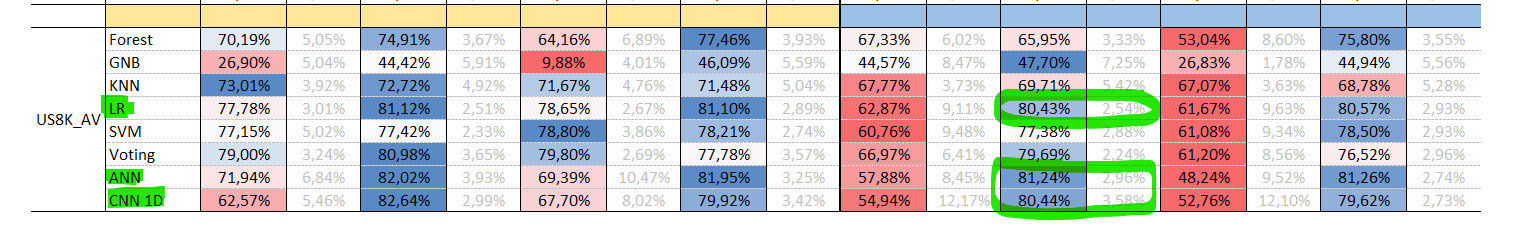

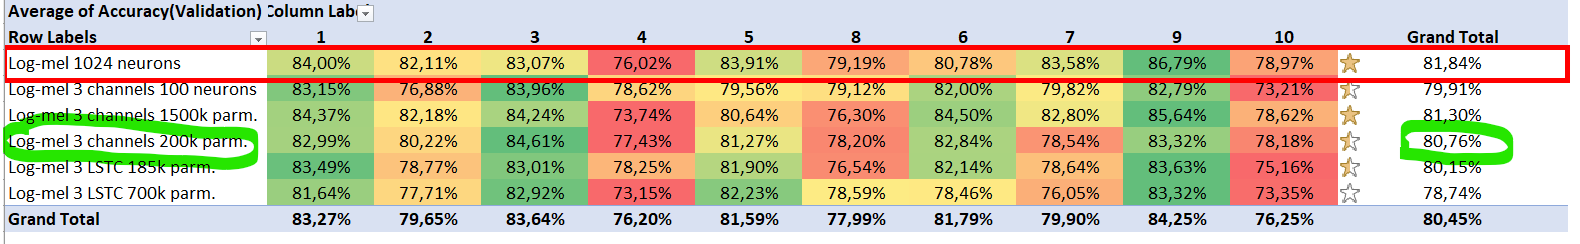

The "Log-mel 1024 neurons" and "Log-mel 3 channels 1500h param." models wer not choosen give its huge numbers of parameters (15.5M and 1.5M respectively). The third best model was defined instead as a compromise between accuracy and size.

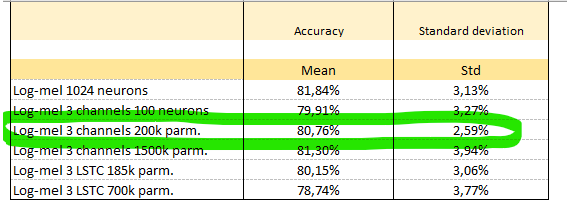


***
For the next steps, the fold 1 will be chosen as the validation set given it's presence in all selected classifiers.

* Fold 1 samples (validation): 2,968
* Training samples: 27,538 (24,784 training / 2,754 testing)
* Total:  30,506

***

## Checking the results with the classifiers saved models

### SVC - Expected results for fold 1 validation: 73.48%

Images from the file: 02_PreProcessing_and_ML_modeling_US8K_AV.ipynb

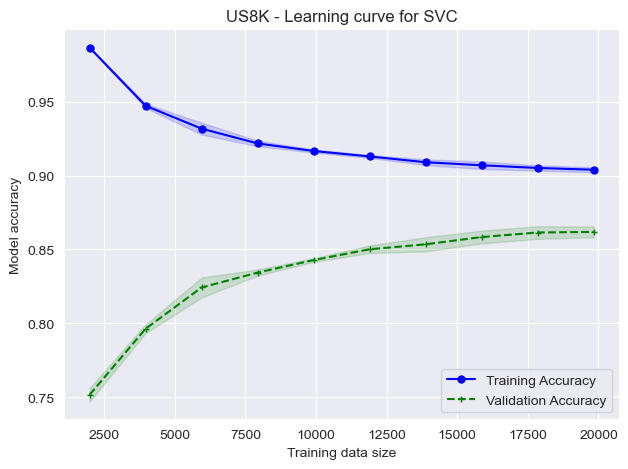
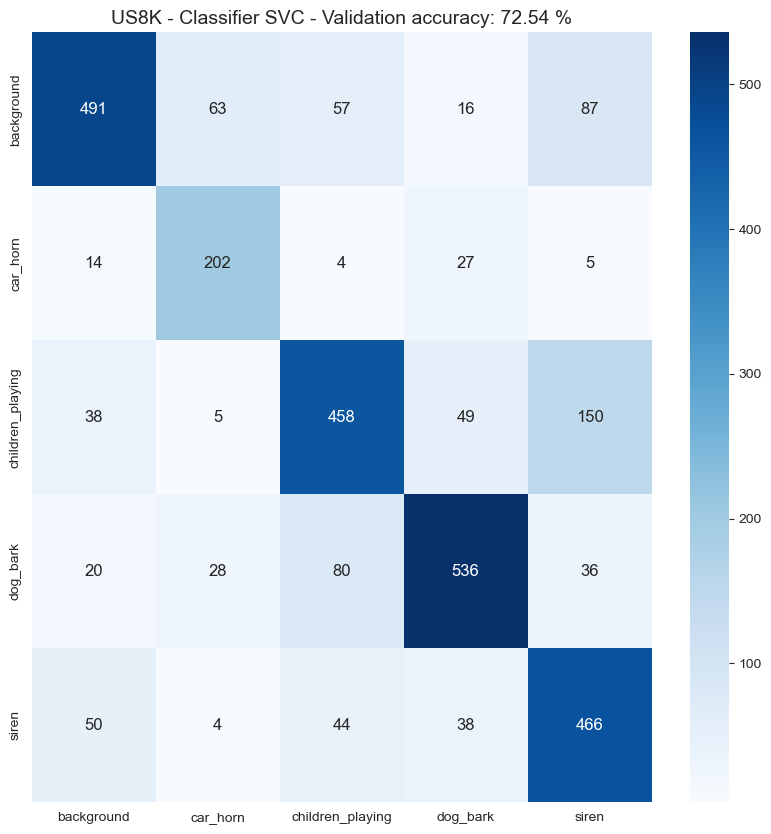

In [57]:
# Load the classifier from file

with open(path_models + 'Model_SVC.pkl', 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [58]:
score_SVC_c_saved = SVC_c_saved.score(X_val_std, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))

Test score (R2): 72.54 %


In [59]:
score_SVC_c_saved

0.7254043126684636

In [60]:
t_srt                   = time.perf_counter_ns()
SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_std)
t_end                   = time.perf_counter_ns()
proc_time               = ((t_end - t_srt) / 1000000)

print(SVC_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_std)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_std),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'car_horn' 'car_horn' 'car_horn']

Number of predicted samples..: 2968
Total predicting time:.......: 6086.4611ms
Predicting time per sample...: 2.050694ms


In [61]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.80      0.69      0.74       714
        car_horn       0.67      0.80      0.73       252
children_playing       0.71      0.65      0.68       700
        dog_bark       0.80      0.77      0.78       700
           siren       0.63      0.77      0.69       602

        accuracy                           0.73      2968
       macro avg       0.72      0.74      0.73      2968
    weighted avg       0.73      0.73      0.73      2968



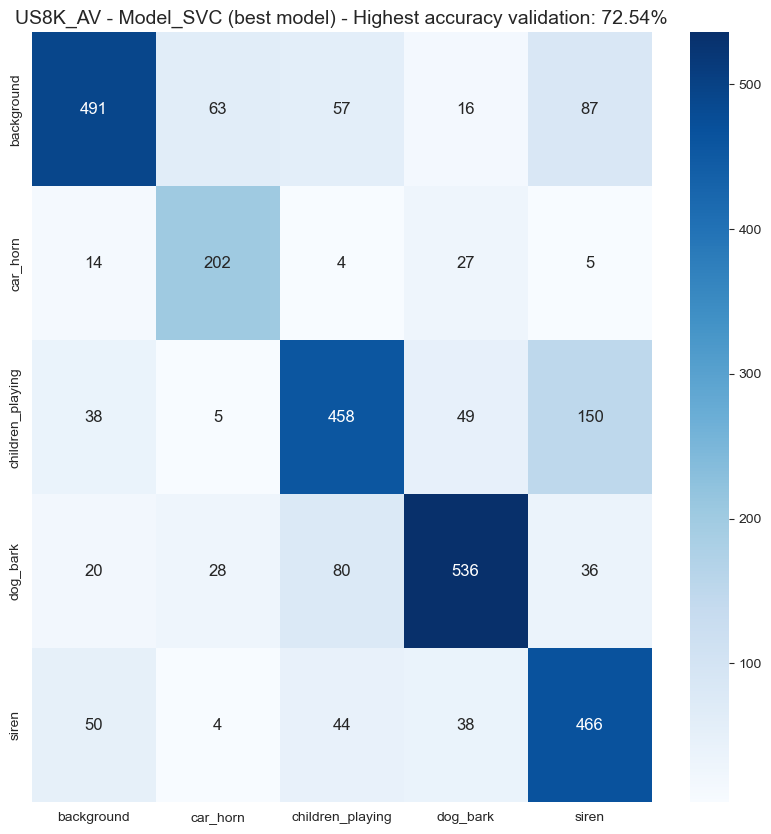

In [62]:
plot_confusion_matrix(y_val_cat, SVC_c_saved_predict_val, score_SVC_c_saved, cmap_cm, 'Model_SVC_confusion_matrix')

### Expected results for fold 1 validation - LR: 80.43%

Images from the file: 02_PreProcessing_and_ML_modeling_US8K_AV.ipynb

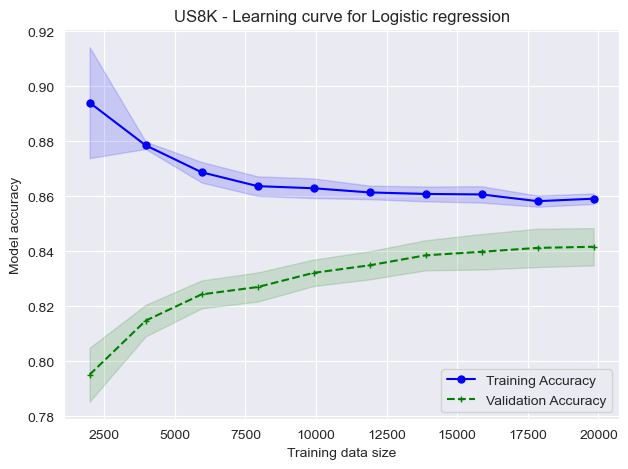
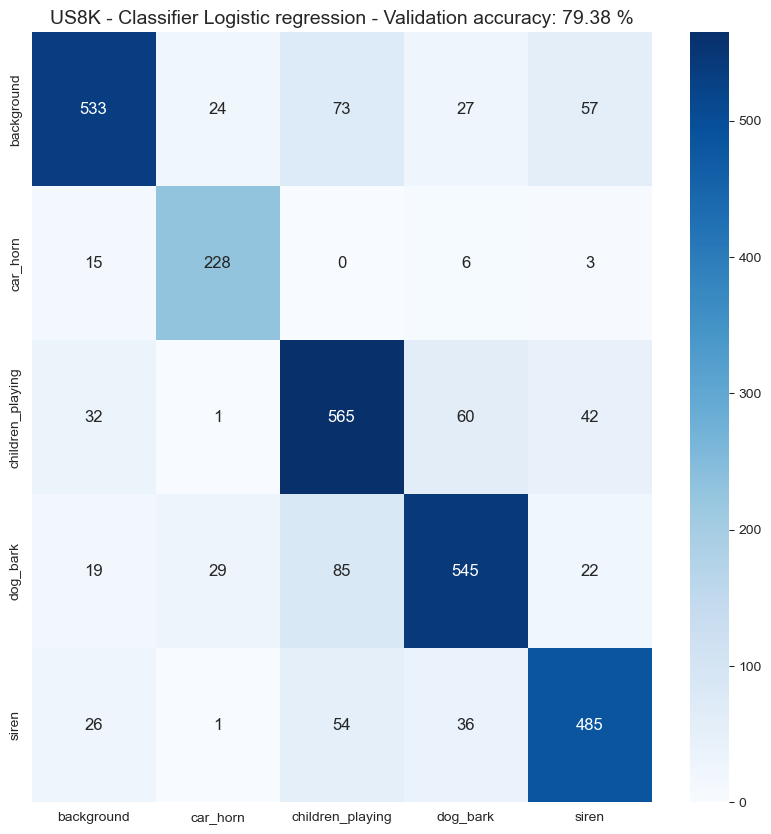

In [63]:
# Load the classifier from file

with open(path_models + 'Model_LR.pkl', 'rb') as file:
    LR_c_saved = pickle.load(file)

In [64]:
score_LR_c_saved = LR_c_saved.score(X_val_std, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_LR_c_saved))

Test score (R2): 79.38 %


In [65]:
score_LR_c_saved

0.793800539083558

In [66]:
t_srt                  = time.perf_counter_ns()
LR_c_saved_predict_val = LR_c_saved.predict(X_val_std)
t_end                  = time.perf_counter_ns()
proc_time              = ((t_end - t_srt) / 1000000)

print(LR_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_std)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_std),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'car_horn' 'car_horn' 'car_horn']

Number of predicted samples..: 2968
Total predicting time:.......: 4.2772ms
Predicting time per sample...: 0.001441ms


In [67]:
for i in LR_c_saved_predict_val:
    print(i)

dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
background
dog_bark
background
background
background
background
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
siren
dog_bark
children_playing
siren
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
backgroun

In [68]:
LR_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                            LR_c_saved_predict_val, 
                                                            target_names = nom_classes, 
                                                            output_dict = False)
print(LR_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.85      0.75      0.80       714
        car_horn       0.81      0.90      0.85       252
children_playing       0.73      0.81      0.77       700
        dog_bark       0.81      0.78      0.79       700
           siren       0.80      0.81      0.80       602

        accuracy                           0.79      2968
       macro avg       0.80      0.81      0.80      2968
    weighted avg       0.80      0.79      0.79      2968



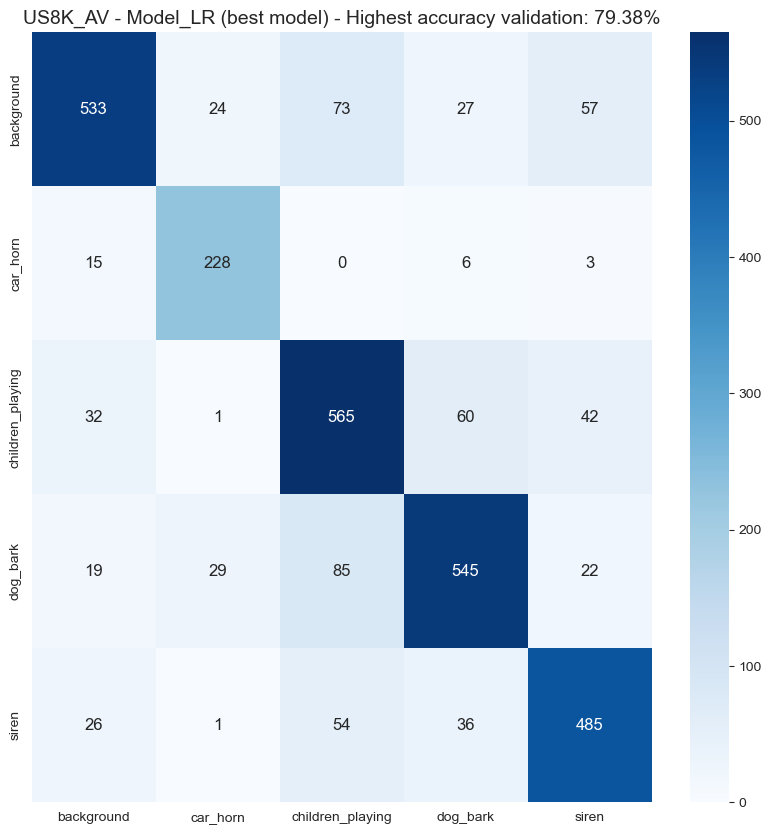

In [69]:
plot_confusion_matrix(y_val_cat, LR_c_saved_predict_val, score_LR_c_saved, cmap_cm, 'Model_LR_confusion_matrix')

### Expected results for fold 1 validation - RF: 80.50%

Images from the file: 02_PreProcessing_and_ML_modeling_US8K_AV.ipynb, considering validation set with original audio length (not windowed).

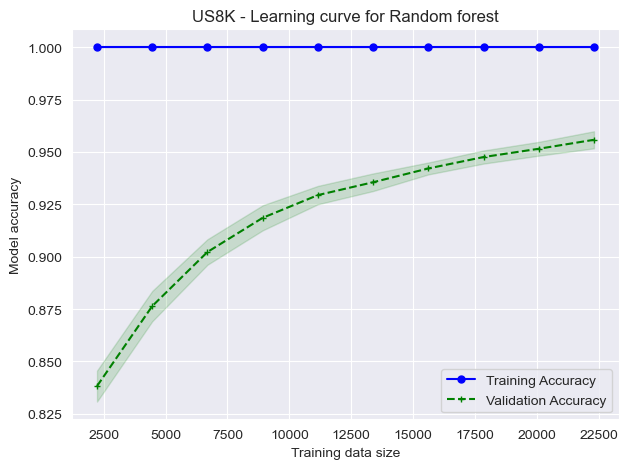
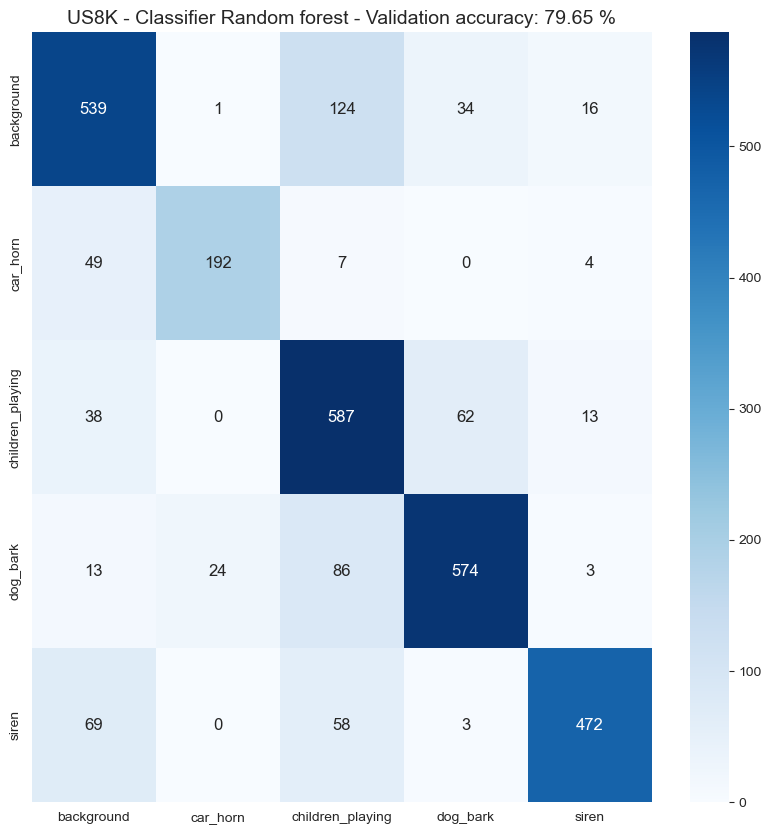

In [70]:
# Retrieve the features indexes after mutual information calculation

mutual_idx_TRN = np.genfromtxt(path_arrays + 'idx_features_mutual.csv', delimiter=',', dtype = int)
mutual_idx_TRN

array([  0,   1,   2,   3,   4,   7,   8,   9,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,
        30,  31,  33,  35,  36,  37,  40,  41,  43,  44,  45,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  59,  60,  70,  77,
        80,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  94, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 118,
       119, 122, 131, 132, 133, 134, 135, 136, 137, 139, 141, 142, 143,
       144, 146, 148, 150, 151, 152, 153, 155, 157, 159, 160, 161, 162,
       164, 166, 168, 170, 175, 177, 178, 179, 180, 184, 186, 187, 188,
       189, 193, 195, 196, 197, 198, 202, 204, 206, 211, 213, 215, 220,
       222, 224, 229, 231, 233, 238, 240, 242, 247, 249, 265, 267, 270,
       271, 272, 276, 283, 284, 285, 286, 287, 289, 290, 291, 292, 294,
       295, 296, 297, 299, 300, 301, 302, 305, 306, 307, 309, 310, 311,
       312, 314, 315, 316, 317, 320, 321, 322, 324, 325, 326, 32

In [71]:
print(len(mutual_idx_TRN))

199


In [72]:
X_train_mutual  = X_train[:, mutual_idx_TRN]
print(X_train_mutual.shape)

X_test_mutual  = X_test[:, mutual_idx_TRN]
print(X_test_mutual.shape)

X_val_mutual  = X_val.values[:, mutual_idx_TRN]
print(X_val_mutual.shape)

(24784, 199)
(2754, 199)
(2968, 199)


In [73]:
# Load the classifier from file

with open(path_models + 'Model_RF.pkl', 'rb') as file:
    RF_c_saved = pickle.load(file)

In [74]:
score_RF_c_saved = RF_c_saved.score(X_val_mutual, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_RF_c_saved))

Test score (R2): 79.65 %


In [75]:
score_RF_c_saved

0.7964959568733153

In [76]:
t_srt                  = time.perf_counter_ns()
RF_c_saved_predict_val = RF_c_saved.predict(X_val_mutual)
t_end                  = time.perf_counter_ns()
proc_time              = ((t_end - t_srt) / 1000000)

print(RF_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_mutual)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_mutual),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'background' 'background'
 'background']

Number of predicted samples..: 2968
Total predicting time:.......: 244.8539ms
Predicting time per sample...: 0.082498ms


In [77]:
RF_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                            RF_c_saved_predict_val, 
                                                            target_names = nom_classes, 
                                                            output_dict = False)
print(RF_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.76      0.75      0.76       714
        car_horn       0.88      0.76      0.82       252
children_playing       0.68      0.84      0.75       700
        dog_bark       0.85      0.82      0.84       700
           siren       0.93      0.78      0.85       602

        accuracy                           0.80      2968
       macro avg       0.82      0.79      0.80      2968
    weighted avg       0.81      0.80      0.80      2968



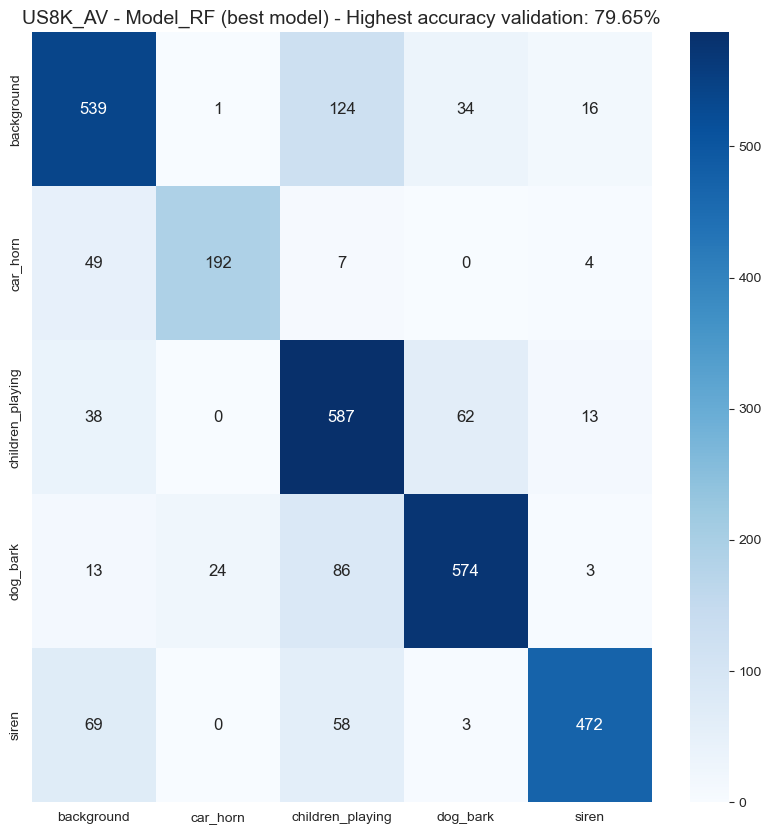

In [78]:
plot_confusion_matrix(y_val_cat, RF_c_saved_predict_val, score_RF_c_saved, cmap_cm, 'Model_RF_confusion_matrix')

### Expected results for fold 1 validation - MLP: 81.24%

Images from the file: 03_Neural_network.ipynb

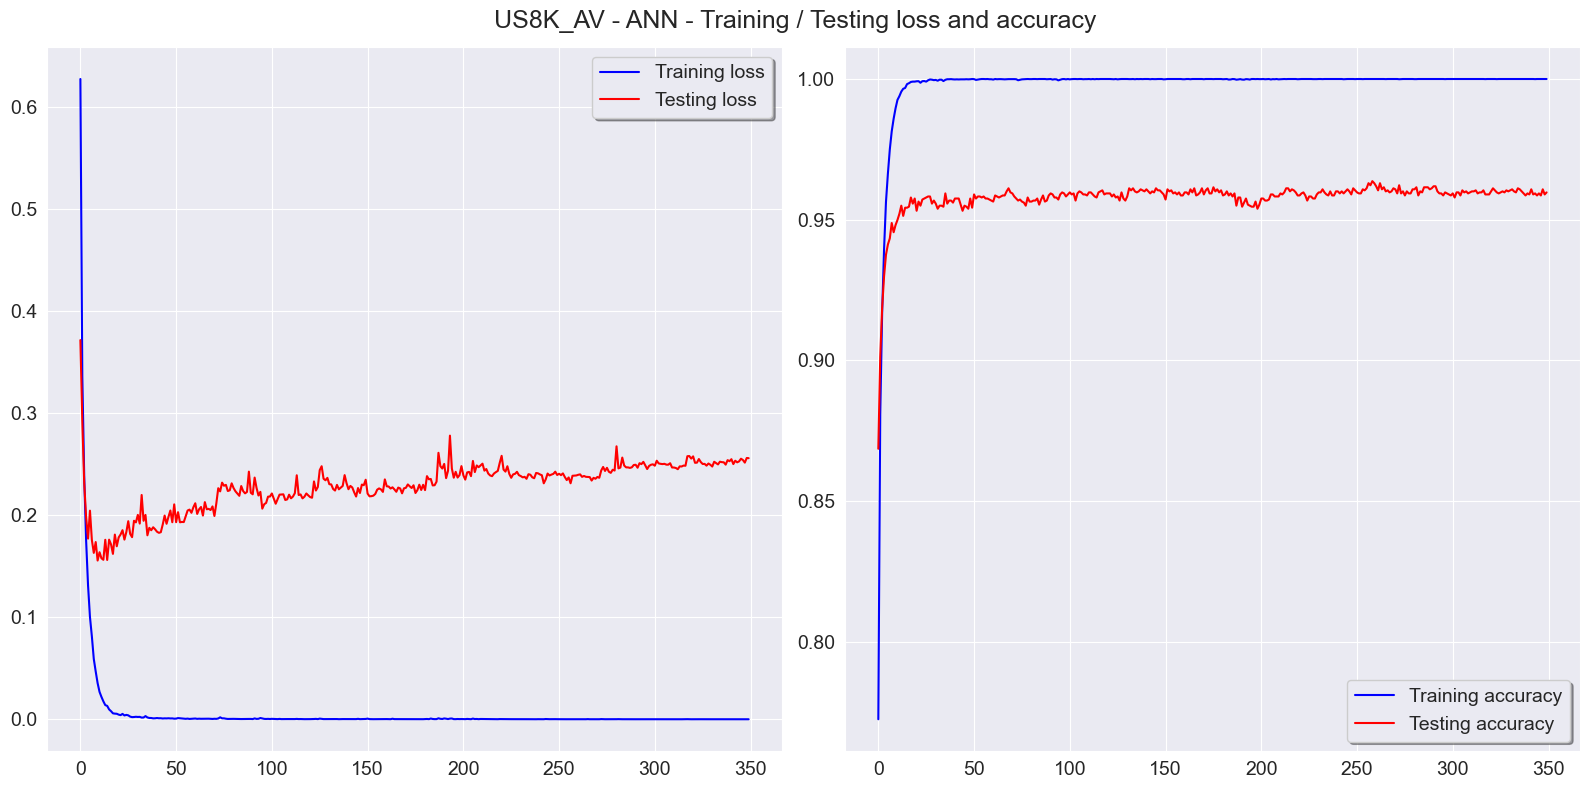
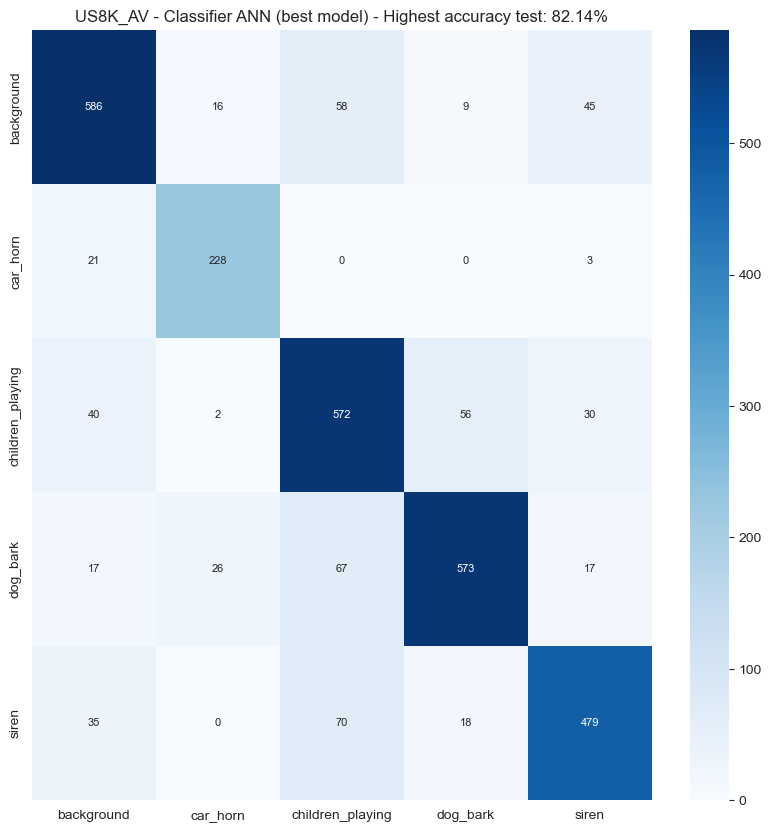

In [79]:
#del model_ANN

In [80]:
# Load the model with the highest accuracy

model_ANN_saved = load_model(path_models + 'Model_ANN_weights_0.best.hdf5')
model_ANN_saved.summary()

Model: "ANN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 375)               141000    
_________________________________________________________________
Hiden_1 (Dense)              (None, 375)               141000    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 375)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               282000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 567,755
Trainable params: 567,755
Non-trainable params: 0
_______________________________________________________

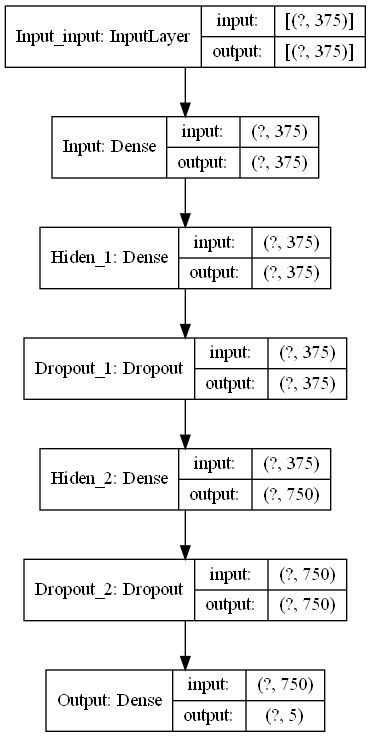

In [81]:
tf.keras.utils.plot_model(model_ANN_saved, to_file= path_models + 'Model_ANN_architecture.png', show_shapes=True)

In [82]:
score_ANN_saved = model_ANN_saved.evaluate(X_val_std, y_val, verbose=1, batch_size = 20)
print('Test loss:', score_ANN_saved[0])
print('Test accuracy:', score_ANN_saved[1])

149/149 [==============================] - 0s 2ms/step - loss: 3.1436 - accuracy: 0.8214
Test loss: 3.143598794937134
Test accuracy: 0.8214285969734192


In [83]:
score_ANN_saved[1]

0.8214285969734192

In [84]:
t_srt            = time.perf_counter_ns()
y_pred_ANN_saved = np.argmax(model_ANN_saved.predict(X_val_std),axis=1)
t_end            = time.perf_counter_ns()
proc_time        = ((t_end - t_srt) / 1000000)

print(y_pred_ANN_saved)
print(f'\nNumber of predicted samples..: {len(X_val_std)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_std),6)}ms')

[3 3 3 ... 1 1 0]

Number of predicted samples..: 2968
Total predicting time:.......: 264.9526ms
Predicting time per sample...: 0.08927ms


In [85]:
y_test_enc = np.argmax(y_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [86]:
metrics_set_ANN = classification_report(y_test_enc, y_pred_ANN_saved, target_names=nom_classes)
print(metrics_set_ANN)

                  precision    recall  f1-score   support

      background       0.84      0.82      0.83       714
        car_horn       0.84      0.90      0.87       252
children_playing       0.75      0.82      0.78       700
        dog_bark       0.87      0.82      0.85       700
           siren       0.83      0.80      0.81       602

        accuracy                           0.82      2968
       macro avg       0.83      0.83      0.83      2968
    weighted avg       0.82      0.82      0.82      2968



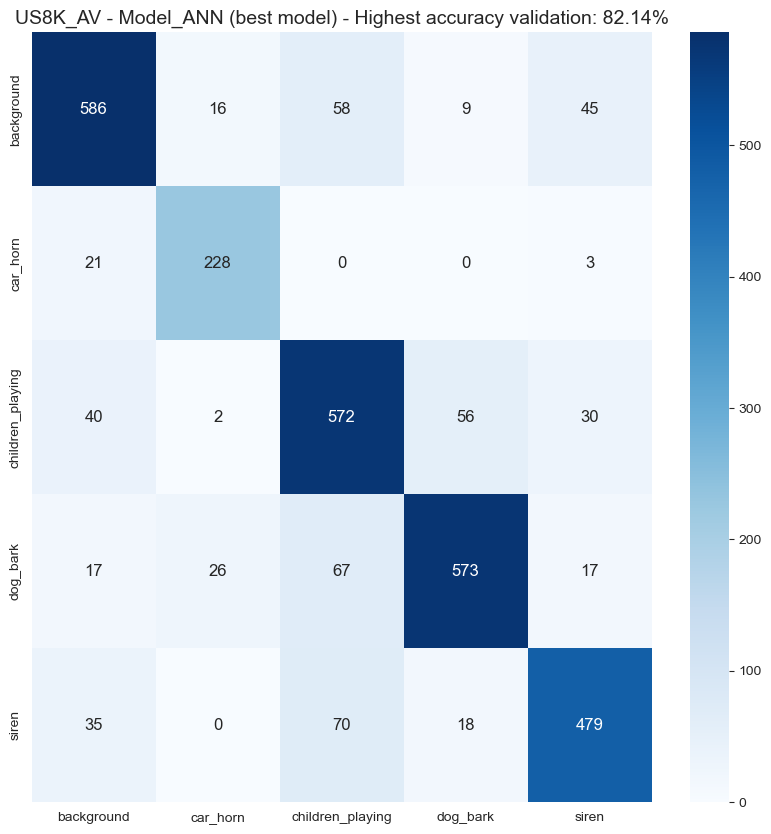

In [87]:
plot_confusion_matrix(y_test_enc, y_pred_ANN_saved, score_ANN_saved, cmap_cm, 'Model_ANN_confusion_matrix')

### Expected results for fold 1 validation - CNN 1D: 80.44%

Images from the file: 03_Neural_network.ipynb

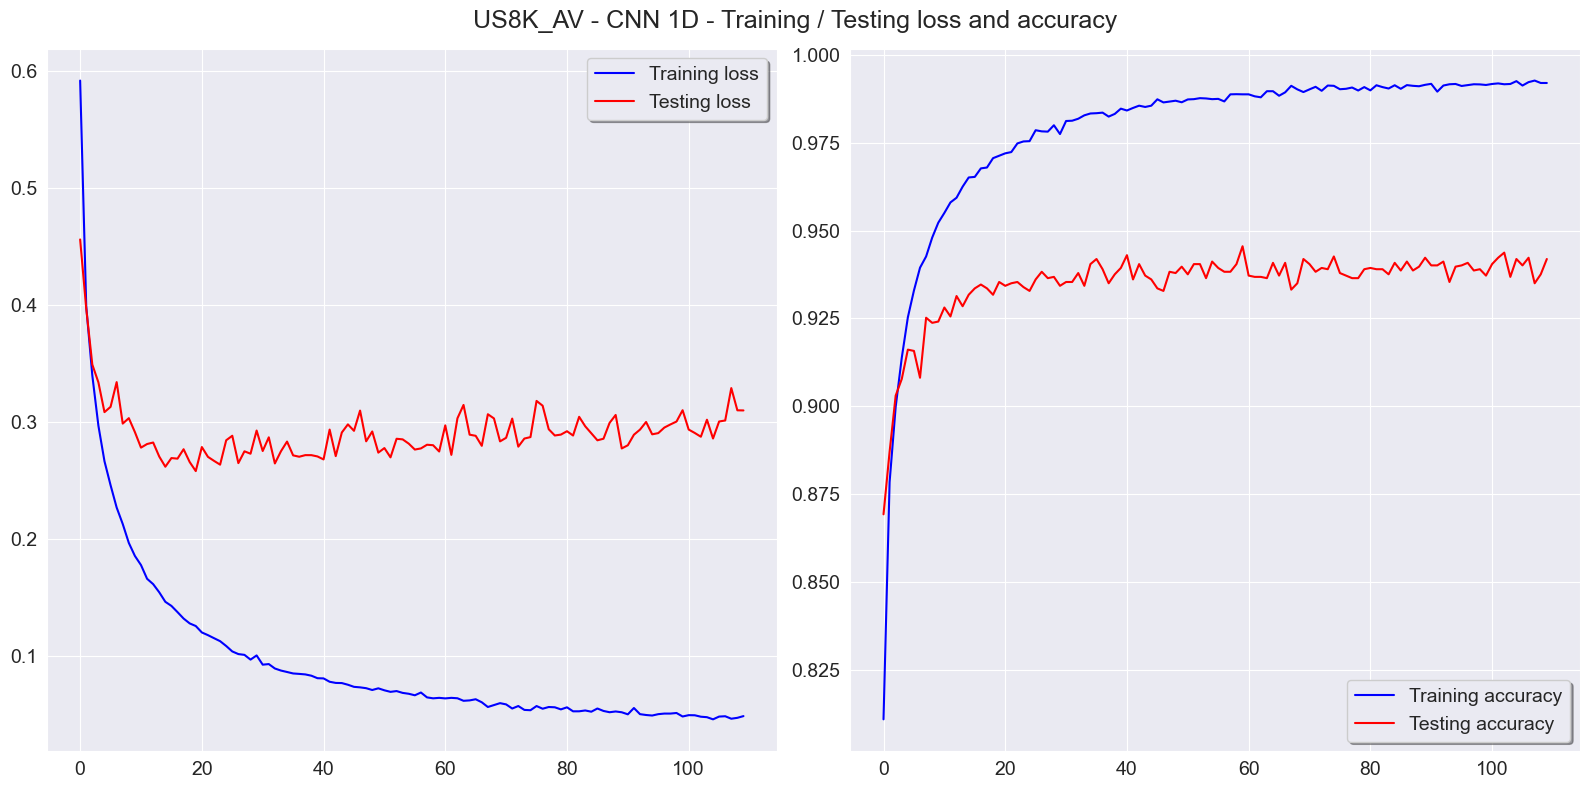
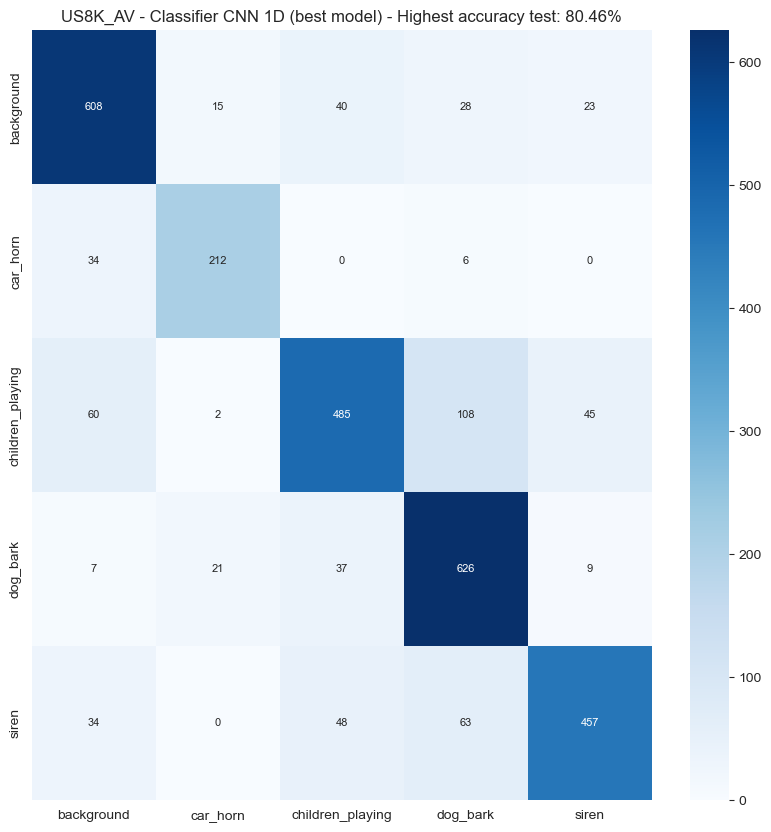

In [88]:
#del model_CNN_1D

In [89]:
# Load the model with the highest accuracy

model_CNN_1D_saved = load_model(path_models + 'Model_CNN_1D_weights_0.best.hdf5')
model_CNN_1D_saved.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 369, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 369, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 369, 56)           5768      
_________________________________________________________________
MaxPool1D_3 (MaxPooling1D)   (None, 184, 56)           0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 184, 56)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10304)             0         
_________________________________________________________________
Dense (Dense)                (None, 50)                51525

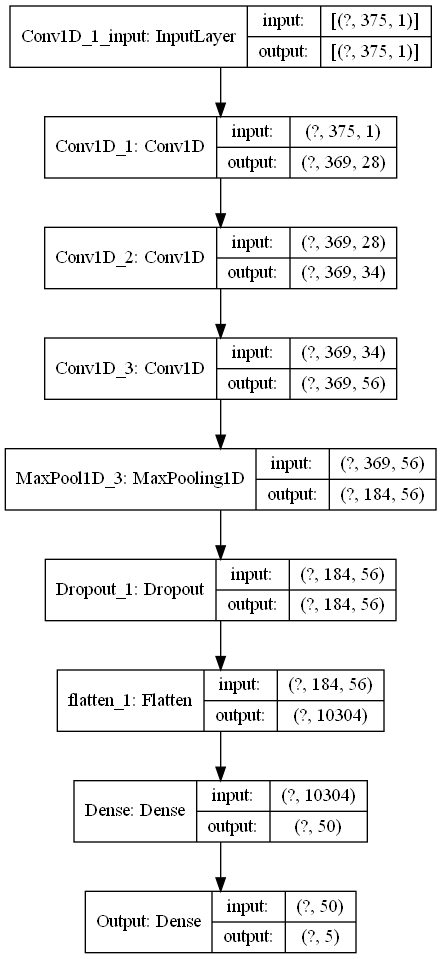

In [90]:
tf.keras.utils.plot_model(model_CNN_1D_saved, to_file= path_models + 'Model_CNN_1D_architecture.png', show_shapes=True)

In [91]:
score_CNN_1D_saved = model_CNN_1D_saved.evaluate(X_val_std[..., np.newaxis], y_val, verbose=1, batch_size = 20)
print('Test loss:', score_CNN_1D_saved[0])
print('Test accuracy:', score_CNN_1D_saved[1])

149/149 [==============================] - 1s 3ms/step - loss: 1.8939 - accuracy: 0.8046
Test loss: 1.8938559293746948
Test accuracy: 0.8045822381973267


In [92]:
score_CNN_1D_saved[1]

0.8045822381973267

In [93]:
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_std[..., np.newaxis]),axis=1)
y_pred_CNN_1D_saved

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [94]:
t_srt               = time.perf_counter_ns()
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_std[..., np.newaxis]),axis=1)
t_end               = time.perf_counter_ns()
proc_time           = ((t_end - t_srt) / 1000000)

print(y_pred_CNN_1D_saved)
print(f'\nNumber of predicted samples..: {len(X_val_std)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_std),6)}ms')

[3 3 3 ... 1 1 1]

Number of predicted samples..: 2968
Total predicting time:.......: 190.1525ms
Predicting time per sample...: 0.064068ms


In [95]:
y_test_enc = np.argmax(y_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [96]:
metrics_set_CNN_1D_saved = classification_report(y_test_enc, y_pred_CNN_1D_saved, target_names=nom_classes)
print(metrics_set_CNN_1D_saved)

                  precision    recall  f1-score   support

      background       0.82      0.85      0.83       714
        car_horn       0.85      0.84      0.84       252
children_playing       0.80      0.69      0.74       700
        dog_bark       0.75      0.89      0.82       700
           siren       0.86      0.76      0.80       602

        accuracy                           0.80      2968
       macro avg       0.81      0.81      0.81      2968
    weighted avg       0.81      0.80      0.80      2968



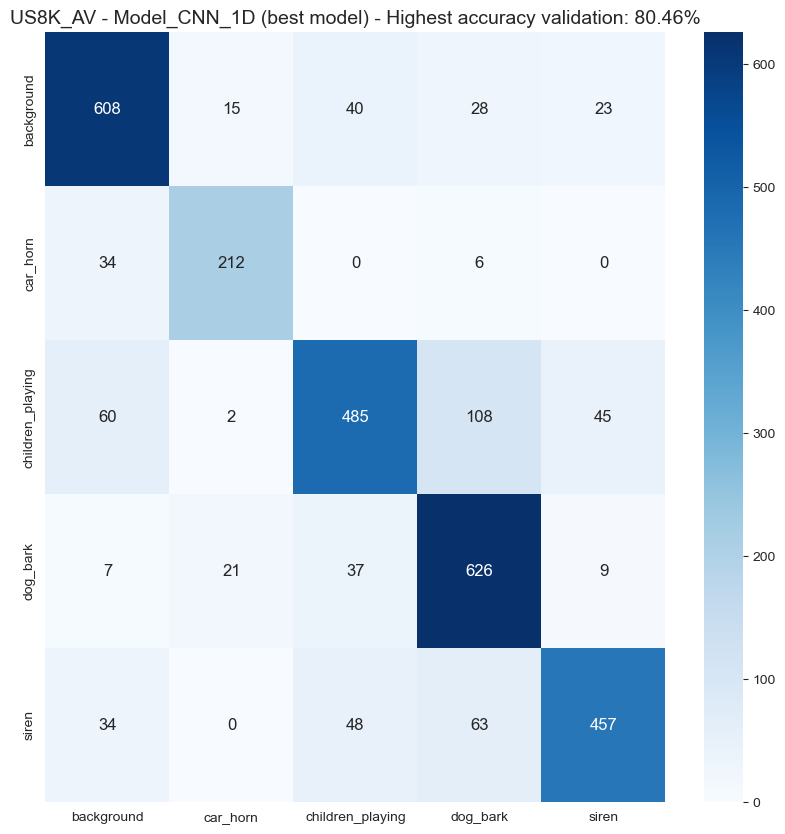

In [97]:
plot_confusion_matrix(y_test_enc, y_pred_CNN_1D_saved, score_CNN_1D_saved, cmap_cm, 'Model_CNN_1D_confusion_matrix')

### Expected results for fold 1 validation - CNN 2D (Log-Mel agg. with delta and delta delta): 80.76%

Images from the file: 05_CNN_2D.ipynb

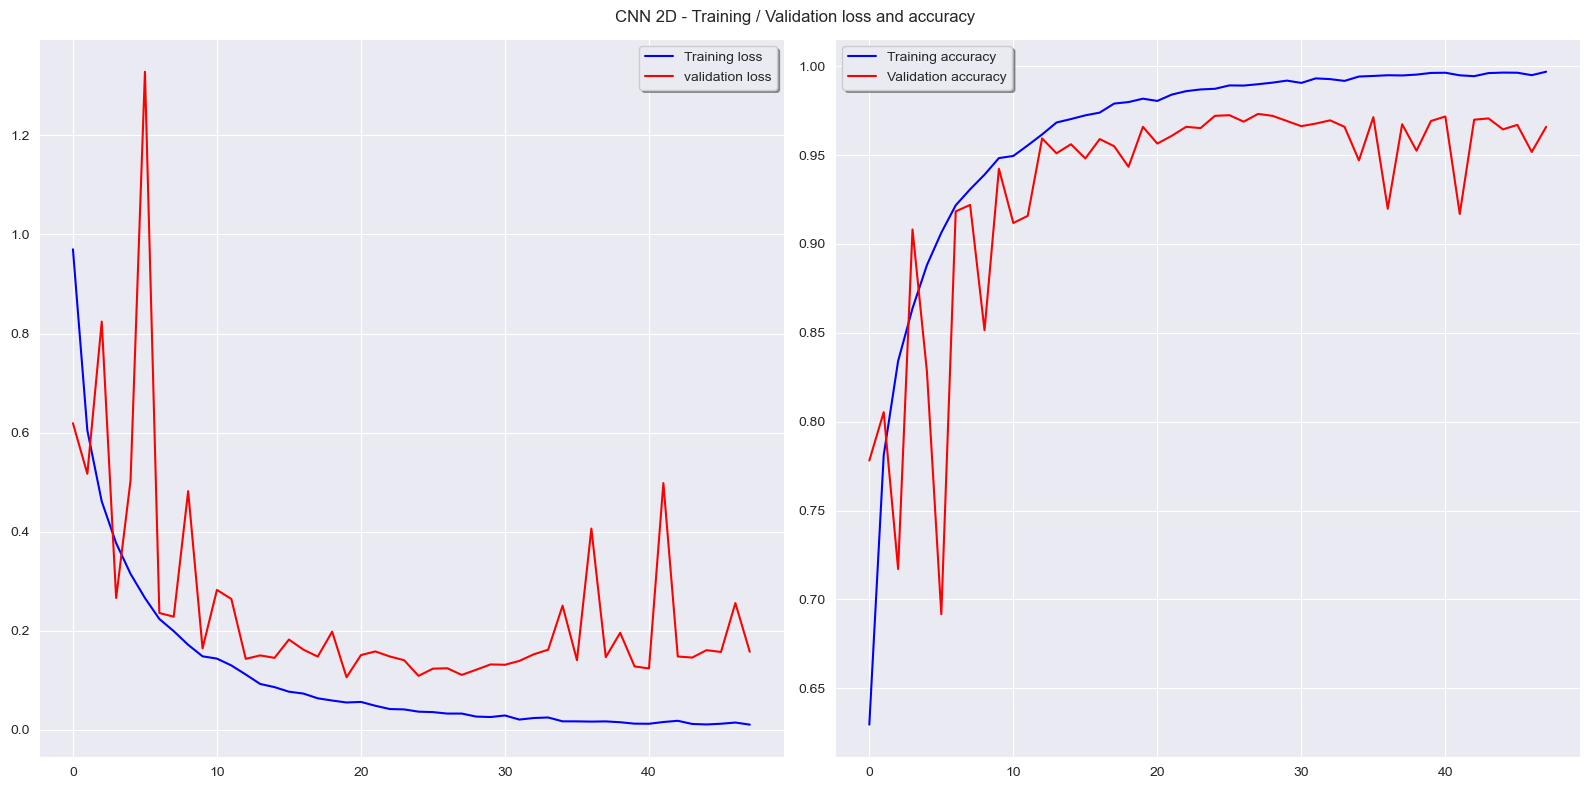
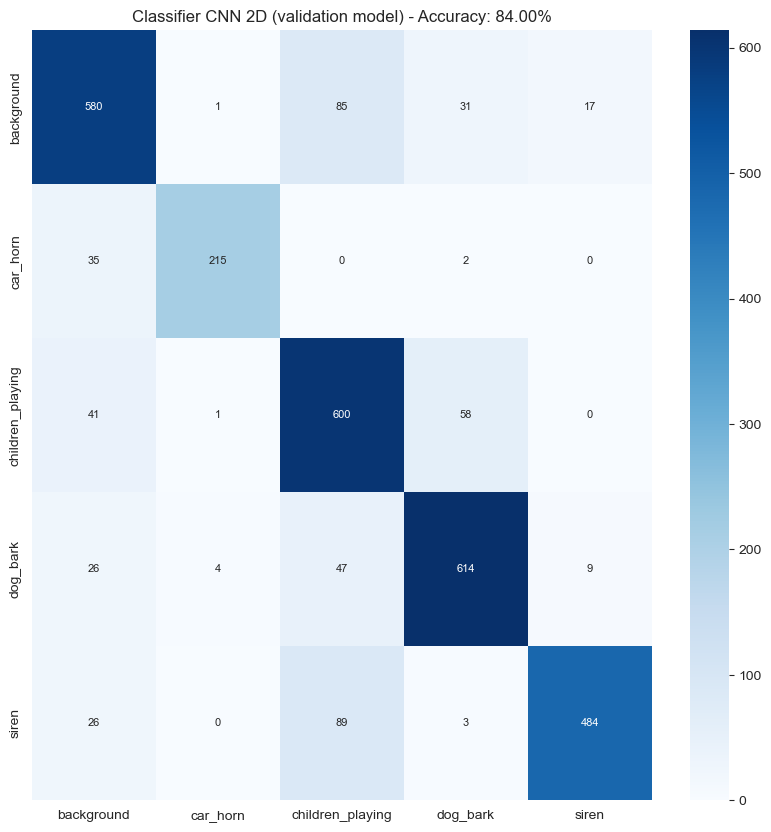

In [98]:
#del model_CNN_2D

In [99]:
# Load the model with the highest accuracy

model_CNN_2D_saved = load_model(path_models + 'Model_CNN_2D_weights_0.best.hdf5')
model_CNN_2D_saved.summary()

Model: "Model_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 44, 24)       96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 22, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 22, 48)        28848     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 22, 48)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 11, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 11, 48)       

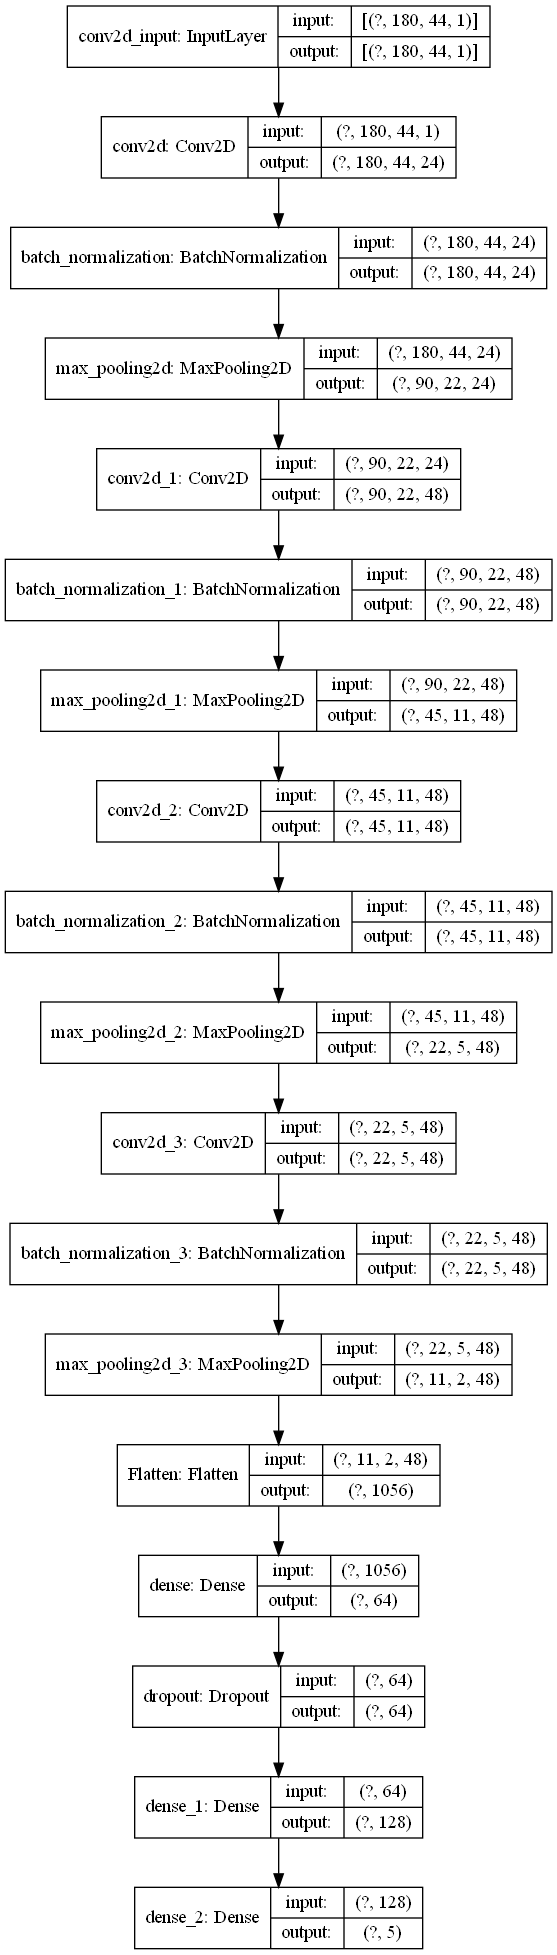

In [100]:
tf.keras.utils.plot_model(model_CNN_2D_saved, to_file= path_models + 'Model_CNN_2D_architecture.png', show_shapes=True)

In [101]:
score_CNN_2D_saved = model_CNN_2D_saved.evaluate(X_val_CNN2D, y_val_CNN2D, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_2D_saved[0])
print('Test accuracy:', score_CNN_2D_saved[1])

93/93 [==============================] - 1s 9ms/step - loss: 0.9986 - accuracy: 0.8400
Test loss: 0.9985979795455933
Test accuracy: 0.8399595618247986


In [102]:
score_CNN_2D_saved[1]

0.8399595618247986

In [103]:
t_srt               = time.perf_counter_ns()
y_pred_CNN_2D_saved = np.argmax(model_CNN_2D_saved.predict(X_val_CNN2D),axis=1)
t_end               = time.perf_counter_ns()
proc_time           = ((t_end - t_srt) / 1000000)

print(y_pred_CNN_2D_saved)
print(f'\nNumber of predicted samples..: {len(X_val_CNN2D)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_CNN2D),6)}ms')

[3 3 3 ... 0 0 0]

Number of predicted samples..: 2968
Total predicting time:.......: 617.7723ms
Predicting time per sample...: 0.208144ms


In [104]:
y_test_enc = np.argmax(y_val_CNN2D, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [105]:
metrics_set_CNN_2D_saved = classification_report(y_test_enc, y_pred_CNN_2D_saved, target_names=nom_classes)
print(metrics_set_CNN_2D_saved)

                  precision    recall  f1-score   support

      background       0.82      0.81      0.82       714
        car_horn       0.97      0.85      0.91       252
children_playing       0.73      0.86      0.79       700
        dog_bark       0.87      0.88      0.87       700
           siren       0.95      0.80      0.87       602

        accuracy                           0.84      2968
       macro avg       0.87      0.84      0.85      2968
    weighted avg       0.85      0.84      0.84      2968



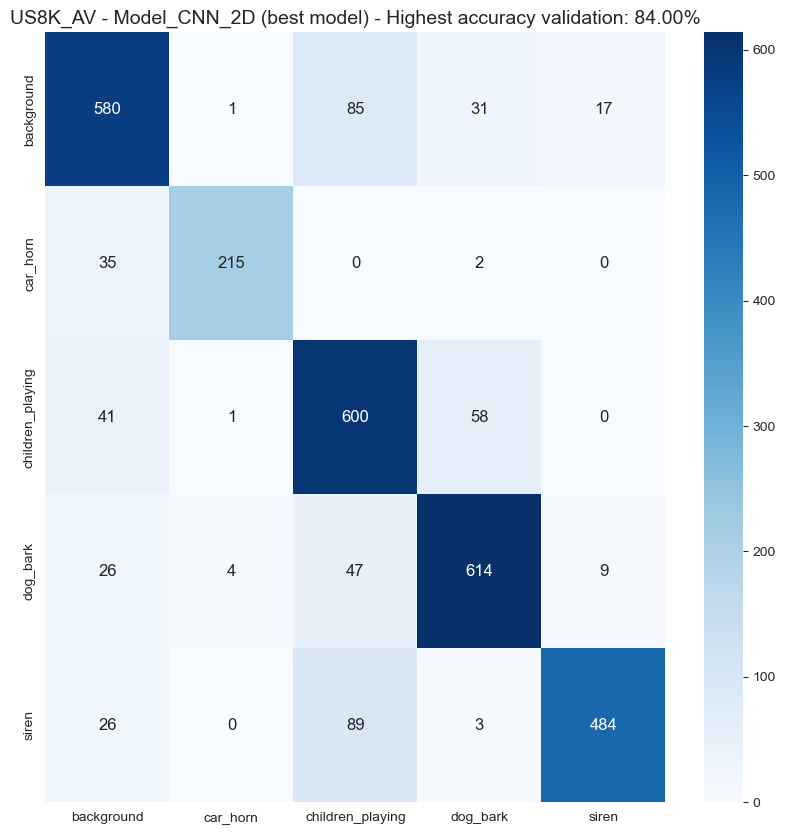

In [106]:
plot_confusion_matrix(y_test_enc, y_pred_CNN_2D_saved, score_CNN_2D_saved, cmap_cm, 'Model_CNN_2D_confusion_matrix')

### Feature extraction evaluation on the validation set

Select the original audio for the validation set

In [106]:
X_val.describe()

RMSE          ZCR    CENTROIDS    BANDWIDTH  ...  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
count  2968.000000  2968.000000  2968.000000  2968.000000  ...    2968.000000       2968.000000     2968.000000         2968.000000
mean      0.064623     0.115167  2060.137683  2022.966388  ...       0.037548         -0.002488        0.123759           -0.309869
std       0.065466     0.090164  1014.839676   520.582812  ...       0.041310          0.044778        0.605493            1.063975
min       0.000058     0.005549   406.477247   695.196438  ...       0.004038         -0.178653       -2.506518           -1.764895
25%       0.014723     0.058555  1357.531838  1642.840623  ...       0.017330         -0.020855       -0.250127           -0.968787
50%       0.039939     0.102262  1920.062821  1955.242881  ...       0.023838         -0.002661        0.126541           -0.563471
75%       0.094029     0.138156  2397.544457  2376.465045  ...       0.036698          0.015404        0.513828            0.012541
max       0.469498     0.770685  6897.406177  3658.796731  ...       0.227059          0.190916        2.530284           12.081950

[8 rows x 375 columns]

In [107]:
X_val_mean_std = pd.DataFrame({'mean': X_val.mean(), 'std': X_val.std()})
X_val_mean_std

mean          std
RMSE                   0.064623     0.065466
ZCR                    0.115167     0.090164
CENTROIDS           2060.137683  1014.839676
BANDWIDTH           2022.966388   520.582812
ROLLOFF             3834.299430  1864.199924
...                         ...          ...
TONNETZ_6              0.001349     0.038136
TONNETZ_std_6          0.037548     0.041310
TONNETZ_median_6      -0.002488     0.044778
TONNETZ_skew_6         0.123759     0.605493
TONNETZ_kurtosis_6    -0.309869     1.063975

[375 rows x 2 columns]

In [107]:
# Mean and standard deviation to be used in the sample standartization

#val_mean = X_val_mean_std.values[:, 0]
#val_std  = X_val_mean_std.values[:, 1]

#val_mean.tofile(path_arrays + 'val_mean.csv', sep=',')
#val_std.tofile(path_arrays  + 'val_std.csv', sep=',')

In [108]:
val_mean = np.genfromtxt(path_arrays + 'val_mean.csv', delimiter=',', dtype = 'float64')
val_std  = np.genfromtxt(path_arrays + 'val_std.csv', delimiter=',', dtype = 'float64')

In [109]:
print(val_mean.shape)
print(val_std.shape)

(375,)
(375,)


In [110]:
val_audioW = np.array(DB_aug_from_pkl_VAL.Audio.to_list())
val_audioW.shape

(2968, 22016)

In [111]:
val_audio = np.array(DB_ori_from_pkl_VAL.Audio.to_list())
val_audio

array([[-1.14854396e-04, -1.70832718e-04, -1.77359616e-04, ...,
        -4.60992791e-02, -4.60947081e-02, -5.09938672e-02],
       [-5.86094859e-04, -1.04031235e-03, -8.36082909e-04, ...,
        -2.57729378e-04, -2.33615778e-04, -3.38456390e-04],
       [ 2.32642919e-01,  3.51767898e-01,  2.96772093e-01, ...,
        -2.87299929e-03, -1.20905112e-03, -1.18477130e-03],
       ...,
       [ 7.60373846e-03, -4.81288135e-02, -8.30650702e-02, ...,
         9.05727372e-02, -4.07979488e-02, -1.54383615e-01],
       [ 1.36899091e-13,  4.11714011e-13,  3.33068100e-13, ...,
        -5.48408702e-02, -4.25563864e-02, -2.65545379e-02],
       [-9.32607353e-02, -3.02354619e-02,  1.19108520e-01, ...,
        -9.58173871e-02, -7.21820071e-02, -3.37771624e-02]], dtype=float32)

In [112]:
val_audio.shape

(424, 88200)

In [113]:
y_val_audio_cat = np.array(DB_ori_from_pkl_VAL.Class_categorical.to_list())
y_val_audio_cat

array(['dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark',
       'dog_bark', 'dog_bark', 'dog_bark', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'siren', 'siren', 'siren', 'siren',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'background', 'dog_bark',
       'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark',
       'dog_bark', 'dog_bark', 'siren', 'siren', 'siren', 'siren',
       'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren',
       'siren', 'siren', 'siren', 'siren', 'dog_bark', 'bac

In [114]:
y_val_audio_cat.shape

(424,)

In [115]:
y_val_audio_cat[1]

'dog_bark'

In [116]:
y_val_audio = np.array(DB_ori_from_pkl_VAL.Class_OHEV.to_list())
y_val_audio

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [117]:
y_val_audio.shape

(424, 5)

In [118]:
ipd.Audio(val_audio[0], rate = SR)

### Apply the windowing technique on each audio

Import the class to window and extract the features of the audio data

In [119]:
from MT_audioPPFE_ML import audioPPFE_ML

In [120]:
def feature_extractor(audioList: list, mutual: bool):
    
    # Start the time
    tExt_srt        = time.perf_counter_ns()

    # Call the class to window and extract the ML features
    PPFE_ML         = audioPPFE_ML(audioList, CNN2D = False, time_length = 4)
    audio_windowed  = np.array(PPFE_ML.audio_windowed)
    audio_features  = np.array(PPFE_ML.features_array)

    # Replace NaN values by 0
    audio_features[np.isnan(audio_features)] = 0
    
    if mutual:
        # Keep original data NEITHER normalized NOR standardized
        audio_features_std = audio_features
    
    else:
        # Standardize using the mean and std from the validation set
        audio_features_std = (audio_features - val_mean) / val_std

    # Stop the timer and compute the extracting time
    tExt_end            = time.perf_counter_ns()
    extract_time        = ((tExt_end - tExt_srt) / 1000000)

    print(f'\nNumber of samples for extraction..: {len(audio_windowed)}')
    print(f'Total extracting time:............: {extract_time:.4f}ms')

    print(f'Extracting time per sample........: {(extract_time/len(audio_windowed)):.4f}ms')
    
    return audio_windowed, audio_features_std

In [122]:
val_audio_windowed, val_audio_features = feature_extractor(val_audio[0:1], mutual = False)


Number of samples for extraction..: 7
Total extracting time:............: 2694.3701ms
Extracting time per sample........: 384.9100ms


In [123]:
val_audio_windowed.shape

(7, 22016)

In [124]:
val_audio_features.shape

(7, 375)

In [125]:
def logMel_extractor(audioList: list):
    
    # Start the time
    tExt_srt        = time.perf_counter_ns()

    # Call the class to window and extract the ML features
    PPFE_ML             = audioPPFE_ML(audioList, CNN2D = True, time_length = 4)
    audio_windowed      = np.array(PPFE_ML.audio_windowed)
    audio_features_agg  = np.array(PPFE_ML.features_agg).astype(np.float32)
    
    # Stop the timer and compute the extracting time
    tExt_end            = time.perf_counter_ns()
    extract_time        = ((tExt_end - tExt_srt) / 1000000)

    print(f'\nNumber of samples for extraction..: {len(audio_windowed)}')
    print(f'Total extracting time:............: {extract_time:.4f}ms')

    print(f'Extracting time per sample........: {(extract_time/len(audio_windowed)):.4f}ms')
    
    return audio_windowed, audio_features_agg

In [127]:
val_audio_windowedCNN2D, val_audio_featuresCNN2D = logMel_extractor(val_audio[0:1])


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 54.1416ms
Extracting time per sample........: 7.7345ms


In [128]:
val_audio_windowedCNN2D.shape

(7, 22016)

In [129]:
val_audio_featuresCNN2D.shape

(7, 180, 44, 1)

In [130]:
def predicSample(classifier: str, samples: list, samplesNr: int):
    
    predict_audioClip = []
    predict_audio     = []

    j = 1

    for i in range(samplesNr):
        print(f'\n=========================================================================')
        print(f'\nSample...: {i}')
        
        # RF - Random Forest
        if classifier   == 'RF':
            # Window and extract the features: NEITHER normalized NOR standardized, rather with Mutual Information
            audio_windowed, audio_features = feature_extractor(samples[i:j], mutual = True)

            # Select the features according the indexes of the Mutual Information applied to the training set
            audio_features_mutual  = audio_features[:, mutual_idx_TRN]

            # Perform the prediction
            predict_val = RF_c_saved.predict(audio_features_mutual)
            print()
            for predict in predict_val:
                print(predict)
            counter = Counter(predict_val)
            predict_audio.append(counter.most_common(1)[0][0])
            print(f'\nAudio is most likely...: {counter.most_common(1)[0][0]}')
            print(f'Ground truth is........: {y_val_audio_cat[i]}')            

            
        # LR - Logistic Regression
        if classifier   == 'LR':
            # Window and extract the features: standardized using mean and std of the validation set
            audio_windowed, audio_features = feature_extractor(samples[i:j], mutual = False)
            
            # Perform the prediction
            predict_val = LR_c_saved.predict(audio_features)
            print()
            for predict in predict_val:
                print(predict)           
            counter = Counter(predict_val)
            predict_audio.append(counter.most_common(1)[0][0])        
            print(f'\nAudio is most likely...: {counter.most_common(1)[0][0]}')
            print(f'Ground truth is........: {y_val_audio_cat[i]}')           

            
        # ANN - Artificial Neural Network or MLP (Multi Layer Perceptron)
        if classifier   == 'ANN':
            # Window and extract the features: standardized using mean and std of the validation set
            audio_windowed, audio_features = feature_extractor(samples[i:j], mutual = False)
            
            # Perform the prediction
            predict_val = np.argmax(model_ANN_saved.predict(audio_features),axis=1)
            print()
            for predict in predict_val:
                print(nom_classes[predict])
            counter = Counter(predict_val)
            predict_audio.append(counter.most_common(1)[0][0])  
            print(f'\nAudio is most likely...: {nom_classes[counter.most_common(1)[0][0]]}')
            print(f'Ground truth is........: {y_val_audio_cat[i]}')                
                

        # CNN1D - Convolutional Neural Network 1D
        if classifier   == 'CNN1D':
            # Window and extract the features: standardized using mean and std of the validation set
            audio_windowed, audio_features = feature_extractor(samples[i:j], mutual = False)
            
            # Perform the prediction
            predict_val = np.argmax(model_CNN_1D_saved.predict(audio_features[..., np.newaxis]),axis=1)
            print()
            for predict in predict_val:
                print(nom_classes[predict])
            counter = Counter(predict_val)
            predict_audio.append(counter.most_common(1)[0][0])  
            print(f'\nAudio is most likely...: {nom_classes[counter.most_common(1)[0][0]]}')
            print(f'Ground truth is........: {y_val_audio_cat[i]}')             

            
        # CNN2D - Convolutional Neural Network 2D
        if classifier   == 'CNN2D':
            # Window and extract the features: standardized using mean and std of the validation set
            audio_windowed, audio_features = logMel_extractor(samples[i:j])

            # Perform the prediction
            predict_val = np.argmax(model_CNN_2D_saved.predict(audio_features),axis=1)
            print()
            for predict in predict_val:
                print(nom_classes[predict])
            counter = Counter(predict_val)
            predict_audio.append(counter.most_common(1)[0][0])  
            print(f'\nAudio is most likely...: {nom_classes[counter.most_common(1)[0][0]]}')
            print(f'Ground truth is........: {y_val_audio_cat[i]}')   
            
      
        predict_audioClip.append(predict_val)
      
        j += 1
    
    return audio_windowed, audio_features, np.array(predict_audioClip).flatten(), predict_audio

In [131]:
#t = 2

In [132]:
classifiers = ['RF', 'LR', 'ANN', 'CNN1D', 'CNN2D']

In [133]:
ipd.Audio(val_audio[1], rate = SR)

In [134]:
# audio_windowed, audio_features  = predicSample(val_audio[t:t+1], 1)

audio_windowed, audio_features, predict_audioClip, predict_audio = predicSample(classifiers[1], val_audio, 1)



Sample...: 0

Number of samples for extraction..: 7
Total extracting time:............: 2790.7511ms
Extracting time per sample........: 398.6787ms

dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


In [135]:
predict_audioClip

array(['dog_bark', 'dog_bark', 'dog_bark', 'children_playing', 'dog_bark',
       'dog_bark', 'dog_bark'], dtype='<U16')

In [136]:
predict_audio

['dog_bark']

In [137]:
audio_windowed.shape

(7, 22016)

In [138]:
audio_features.shape

(7, 375)

In [139]:
classifiers = ['RF', 'LR', 'ANN', 'CNN1D', 'CNN2D']

In [139]:
predict_audioClip_dic = {}
predict_audio_dic     = {}

for classifier in classifiers:
    print(f'\nClassifier....: {classifier}')
    predict_audioClip_classifier = f'predict_audioClip_{classifier}'
    predict_audio_classifier     = f'predict_audio_{classifier}'
    
    audio_windowed, audio_features, predict_audioClip_classifier, predict_audio_classifier = predicSample(classifier, val_audio, len(val_audio))
    
    predict_audioClip_dic[f'predict_audioClip_{classifier}'] = predict_audioClip_classifier
    predict_audio_dic[f'predict_audio_{classifier}'] = predict_audio_classifier



Classifier....: RF


Sample...: 0

Number of samples for extraction..: 7
Total extracting time:............: 1603.9921ms
Extracting time per sample........: 229.1417ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 1

Number of samples for extraction..: 7
Total extracting time:............: 1688.7026ms
Extracting time per sample........: 241.2432ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 2

Number of samples for extraction..: 7
Total extracting time:............: 1703.0085ms
Extracting time per sample........: 243.2869ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 3

Number of samples for extraction..: 7
Total extracting time:............: 1605.8424ms
Extracting time per sample......


Number of samples for extraction..: 7
Total extracting time:............: 1727.6755ms
Extracting time per sample........: 246.8108ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 22

Number of samples for extraction..: 7
Total extracting time:............: 1744.7126ms
Extracting time per sample........: 249.2447ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 23

Number of samples for extraction..: 7
Total extracting time:............: 1741.4068ms
Extracting time per sample........: 248.7724ms

children_playing
children_playing
background
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing


Number of samples for extraction..: 7
Total extracting time:............: 1630.6142ms
Extracting time per sample........: 232.9449ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 43

Number of samples for extraction..: 7
Total extracting time:............: 1649.4578ms
Extracting time per sample........: 235.6368ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 44

Number of samples for extraction..: 7
Total extracting time:............: 1511.7936ms
Extracting time per sample........: 215.9705ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 45

Number of samples for extraction..: 7
Total extracting time:............: 1646.6900ms
Extracting time per sample........: 235.2414ms

dog_bark
dog_bar


Number of samples for extraction..: 7
Total extracting time:............: 1559.0911ms
Extracting time per sample........: 222.7273ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 66

Number of samples for extraction..: 7
Total extracting time:............: 1589.0092ms
Extracting time per sample........: 227.0013ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 67

Number of samples for extraction..: 7
Total extracting time:............: 1618.4766ms
Extracting time per sample........: 231.2109ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 68

Number of samples for extraction..: 7
Total extracting time:............: 1613.7310ms
Extracting time per sample..


Number of samples for extraction..: 7
Total extracting time:............: 1533.6147ms
Extracting time per sample........: 219.0878ms

children_playing
dog_bark
children_playing
children_playing
children_playing
dog_bark
dog_bark

Audio is most likely...: children_playing
Ground truth is........: dog_bark


Sample...: 87

Number of samples for extraction..: 7
Total extracting time:............: 1536.2362ms
Extracting time per sample........: 219.4623ms

dog_bark
siren
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 88

Number of samples for extraction..: 7
Total extracting time:............: 1531.4805ms
Extracting time per sample........: 218.7829ms

dog_bark
dog_bark
siren
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 89

Number of samples for extraction..: 7
Total extracting time:............: 1580.4766ms
Extracting tim


Number of samples for extraction..: 7
Total extracting time:............: 1607.4932ms
Extracting time per sample........: 229.6419ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 108

Number of samples for extraction..: 7
Total extracting time:............: 1600.1766ms
Extracting time per sample........: 228.5967ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 109

Number of samples for extraction..: 7
Total extracting time:............: 1530.0663ms
Extracting time per sample........: 218.5809ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 110

Number of samples for extraction..: 7
T


Number of samples for extraction..: 7
Total extracting time:............: 1552.2945ms
Extracting time per sample........: 221.7564ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 130

Number of samples for extraction..: 7
Total extracting time:............: 1609.6871ms
Extracting time per sample........: 229.9553ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 131

Number of samples for extraction..: 7
Total extracting time:............: 1601.8099ms
Extracting time per sample........: 228.8300ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 132

Number of samples for extraction..: 7
Total extracting time:............: 1535.0923ms
Extracting time per sample........: 219.2989ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is.....


Number of samples for extraction..: 7
Total extracting time:............: 1607.3389ms
Extracting time per sample........: 229.6198ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 155

Number of samples for extraction..: 7
Total extracting time:............: 1591.7699ms
Extracting time per sample........: 227.3957ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 156

Number of samples for extraction..: 7
Total extracting time:............: 1592.4400ms
Extracting time per sample........: 227.4914ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 157

Number of samples for extraction..: 7
Total extracting time:............: 1577.4726ms
Extracting time per sample........: 225.3532ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is.....


Number of samples for extraction..: 7
Total extracting time:............: 1557.0587ms
Extracting time per sample........: 222.4370ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 179

Number of samples for extraction..: 7
Total extracting time:............: 1548.5272ms
Extracting time per sample........: 221.2182ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 180

Number of samples for extraction..: 7
Total extracting time:............: 1543.7975ms
Extracting time per sample........: 220.5425ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children


Number of samples for extraction..: 7
Total extracting time:............: 1603.9369ms
Extracting time per sample........: 229.1338ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 202

Number of samples for extraction..: 7
Total extracting time:............: 1636.5839ms
Extracting time per sample........: 233.7977ms

children_playing
background
background
dog_bark
dog_bark
dog_bark
children_playing

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 203

Number of samples for extraction..: 7
Total extracting time:............: 1594.7555ms
Extracting time per sample........: 227.8222ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_p


Number of samples for extraction..: 7
Total extracting time:............: 1789.8091ms
Extracting time per sample........: 255.6870ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 224

Number of samples for extraction..: 7
Total extracting time:............: 1652.7068ms
Extracting time per sample........: 236.1010ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 225

Number of samples for extraction..: 7
Total extracting time:............: 1720.3658ms
Extracting time per sample........: 245.7665ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 226

Number of samples for extraction..: 7
Total extracting time:............: 1


Number of samples for extraction..: 7
Total extracting time:............: 1629.5960ms
Extracting time per sample........: 232.7994ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 246

Number of samples for extraction..: 7
Total extracting time:............: 1602.2134ms
Extracting time per sample........: 228.8876ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 247

Number of samples for extraction..: 7
Total extracting time:............: 1602.3650ms
Extracting time per sample........: 228.9093ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 248

Number of samples for extraction..: 7
Total extracting time:............: 1687.7919ms
Extract


Number of samples for extraction..: 7
Total extracting time:............: 1625.2277ms
Extracting time per sample........: 232.1754ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 267

Number of samples for extraction..: 7
Total extracting time:............: 1579.8049ms
Extracting time per sample........: 225.6864ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 268

Number of samples for extraction..: 7
Total extracting time:............: 1574.4487ms
Extracting time per sample........: 224.9212ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 269

Num


Number of samples for extraction..: 7
Total extracting time:............: 1649.8507ms
Extracting time per sample........: 235.6930ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 288

Number of samples for extraction..: 7
Total extracting time:............: 1607.4685ms
Extracting time per sample........: 229.6384ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 289

Number of samples for extraction..: 7
Total extracting time:............: 1594.6279ms
Extracting time per sample........: 227.8040ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children


Number of samples for extraction..: 7
Total extracting time:............: 1601.1641ms
Extracting time per sample........: 228.7377ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: dog_bark


Sample...: 309

Number of samples for extraction..: 7
Total extracting time:............: 1551.2377ms
Extracting time per sample........: 221.6054ms

children_playing
children_playing
children_playing
children_playing
dog_bark
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: dog_bark


Sample...: 310

Number of samples for extraction..: 7
Total extracting time:............: 1576.9420ms
Extracting time per sample........: 225.2774ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 311

Number of


Number of samples for extraction..: 7
Total extracting time:............: 1584.9514ms
Extracting time per sample........: 226.4216ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 332

Number of samples for extraction..: 7
Total extracting time:............: 1538.0092ms
Extracting time per sample........: 219.7156ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 333

Number of samples for extraction..: 7
Total extracting time:............: 1565.4509ms
Extracting time per sample........: 223.6358ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 334

Number of samples for extraction..: 7
Total extracting time:............: 1553.7375ms
Extracting time per sample........: 221.9625ms

dog_bark
dog_


Number of samples for extraction..: 7
Total extracting time:............: 1567.8904ms
Extracting time per sample........: 223.9843ms

dog_bark
dog_bark
car_horn
dog_bark
dog_bark
car_horn
car_horn

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 355

Number of samples for extraction..: 7
Total extracting time:............: 1559.0588ms
Extracting time per sample........: 222.7227ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: dog_bark


Sample...: 356

Number of samples for extraction..: 7
Total extracting time:............: 1642.4574ms
Extracting time per sample........: 234.6368ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: dog_bark


Sample...: 357

Number of samples for extraction..: 7
Total extracting time:............: 1621.0873ms
Extracting time per sample........: 231.5839ms

dog_bark
dog_


Number of samples for extraction..: 7
Total extracting time:............: 1558.8186ms
Extracting time per sample........: 222.6884ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 377

Number of samples for extraction..: 7
Total extracting time:............: 1596.2875ms
Extracting time per sample........: 228.0411ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 378

Number of samples for extraction..: 7
Total extracting time:............: 1682.1839ms
Extracting time per sample........: 240.3120ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 379

Number of samples for extraction..: 7
Total extracting time:............: 1616.4460ms
Extracting time per sample........: 230.920


Number of samples for extraction..: 7
Total extracting time:............: 1567.8445ms
Extracting time per sample........: 223.9778ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: car_horn


Sample...: 400

Number of samples for extraction..: 7
Total extracting time:............: 1505.6537ms
Extracting time per sample........: 215.0934ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: car_horn


Sample...: 401

Number of samples for extraction..: 7
Total extracting time:............: 1535.9391ms
Extracting time per sample........: 219.4199ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: car_horn


Sample...: 402

Number of samples for extraction..: 7
Total extracting time:............: 1551.9413ms
Extracting ti


Number of samples for extraction..: 7
Total extracting time:............: 1551.3175ms
Extracting time per sample........: 221.6168ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 422

Number of samples for extraction..: 7
Total extracting time:............: 1581.1431ms
Extracting time per sample........: 225.8776ms

dog_bark
dog_bark
dog_bark
dog_bark
background
background
background

Audio is most likely...: dog_bark
Ground truth is........: background


Sample...: 423

Number of samples for extraction..: 7
Total extracting time:............: 1569.0651ms
Extracting time per sample........: 224.1522ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background

Classifier....: LR


Sample...: 0

Number of samples for extraction..: 7
Total extracting time:............: 1584.3003ms


Number of samples for extraction..: 7
Total extracting time:............: 1553.9550ms
Extracting time per sample........: 221.9936ms

background
background
background
background
background
children_playing
children_playing

Audio is most likely...: background
Ground truth is........: background


Sample...: 21

Number of samples for extraction..: 7
Total extracting time:............: 1594.1384ms
Extracting time per sample........: 227.7341ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 22

Number of samples for extraction..: 7
Total extracting time:............: 1515.3240ms
Extracting time per sample........: 216.4749ms

siren
siren
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 23


Number of samples for extraction..: 7
Total extracting time:............: 1595.5029ms
Extracting time per sample........: 227.9290ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 41

Number of samples for extraction..: 7
Total extracting time:............: 1558.2678ms
Extracting time per sample........: 222.6097ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 42

Number of samples for extraction..: 7
Total extracting time:............: 1532.2679ms
Extracting time per sample........: 218.8954ms

dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 43

Number of samples for extraction..: 7
Total extracti


Number of samples for extraction..: 7
Total extracting time:............: 1532.4146ms
Extracting time per sample........: 218.9164ms

car_horn
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 65

Number of samples for extraction..: 7
Total extracting time:............: 1562.3290ms
Extracting time per sample........: 223.1899ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 66

Number of samples for extraction..: 7
Total extracting time:............: 1578.7444ms
Extracting time per sample........: 225.5349ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 67

Number of samples for extraction..: 7
Total extracting time:............: 1547.2624ms
Extracting time per sample........: 221.0375ms

background
background



Number of samples for extraction..: 7
Total extracting time:............: 1601.2704ms
Extracting time per sample........: 228.7529ms

siren
siren
dog_bark
siren
siren
siren
dog_bark

Audio is most likely...: siren
Ground truth is........: dog_bark


Sample...: 87

Number of samples for extraction..: 7
Total extracting time:............: 1577.4827ms
Extracting time per sample........: 225.3547ms

children_playing
dog_bark
children_playing
children_playing
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 88

Number of samples for extraction..: 7
Total extracting time:............: 1577.3270ms
Extracting time per sample........: 225.3324ms

children_playing
siren
siren
dog_bark
dog_bark
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 89

Number of samples for extraction..: 7
Total extracting time:............: 1568.3906ms
Extracting time 


Number of samples for extraction..: 7
Total extracting time:............: 1567.9143ms
Extracting time per sample........: 223.9878ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 108

Number of samples for extraction..: 7
Total extracting time:............: 1560.4913ms
Extracting time per sample........: 222.9273ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 109

Number of samples for extraction..: 7
Total extracting time:............: 1579.6239ms
Extracting time per sample........: 225.6606ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 110

Number of samples for extraction..: 7
T


Number of samples for extraction..: 7
Total extracting time:............: 1604.8006ms
Extracting time per sample........: 229.2572ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 130

Number of samples for extraction..: 7
Total extracting time:............: 1569.0733ms
Extracting time per sample........: 224.1533ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 131

Number of samples for extraction..: 7
Total extracting time:............: 1559.8111ms
Extracting time per sample........: 222.8302ms

siren
siren
siren
siren
siren
siren
dog_bark

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 132

Number of samples for extraction..: 7
Total extracting time:............: 1504.6842ms
Extracting time per sample........: 214.9549ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is..


Number of samples for extraction..: 7
Total extracting time:............: 1573.7825ms
Extracting time per sample........: 224.8261ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 155

Number of samples for extraction..: 7
Total extracting time:............: 1619.1578ms
Extracting time per sample........: 231.3083ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 156

Number of samples for extraction..: 7
Total extracting time:............: 1558.2730ms
Extracting time per sample........: 222.6104ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 157

Number of samples for extraction..: 7
Total extracting time:............: 1618.7349ms
Extracting time per sample........: 231.2478ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is.....


Number of samples for extraction..: 7
Total extracting time:............: 1548.6689ms
Extracting time per sample........: 221.2384ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 179

Number of samples for extraction..: 7
Total extracting time:............: 1553.9124ms
Extracting time per sample........: 221.9875ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 180

Number of samples for extraction..: 7
Total extracting time:............: 1560.0116ms
Extracting time per sample........: 222.8588ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children


Number of samples for extraction..: 7
Total extracting time:............: 1548.7153ms
Extracting time per sample........: 221.2450ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 202

Number of samples for extraction..: 7
Total extracting time:............: 1556.2211ms
Extracting time per sample........: 222.3173ms

children_playing
background
background
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 203

Number of samples for extraction..: 7
Total extracting time:............: 1584.6919ms
Extracting time per sample........: 226.3846ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Gro


Number of samples for extraction..: 7
Total extracting time:............: 1550.4296ms
Extracting time per sample........: 221.4899ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 224

Number of samples for extraction..: 7
Total extracting time:............: 1572.2888ms
Extracting time per sample........: 224.6127ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 225

Number of samples for extraction..: 7
Total extracting time:............: 1592.5577ms
Extracting time per sample........: 227.5082ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 226

Number of samples for extraction..: 7
Total extracting time:............: 1


Number of samples for extraction..: 7
Total extracting time:............: 1560.5619ms
Extracting time per sample........: 222.9374ms

car_horn
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 246

Number of samples for extraction..: 7
Total extracting time:............: 1595.7457ms
Extracting time per sample........: 227.9637ms

car_horn
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 247

Number of samples for extraction..: 7
Total extracting time:............: 1590.3599ms
Extracting time per sample........: 227.1943ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 248

Number of samples for extraction..: 7
Total extracting time:............: 1585.1106ms
Extracting 


Number of samples for extraction..: 7
Total extracting time:............: 1520.0363ms
Extracting time per sample........: 217.1480ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 268

Number of samples for extraction..: 7
Total extracting time:............: 1577.1172ms
Extracting time per sample........: 225.3025ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 269

Number of samples for extraction..: 7
Total extracting time:............: 1555.8226ms
Extracting time per sample........: 222.2604ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 270

Number of samples for extraction..: 7
Total extracting time:............: 1


Number of samples for extraction..: 7
Total extracting time:............: 1560.2824ms
Extracting time per sample........: 222.8975ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 289

Number of samples for extraction..: 7
Total extracting time:............: 1562.5229ms
Extracting time per sample........: 223.2176ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 290

Number of samples for extraction..: 7
Total extracting time:............: 1575.4169ms
Extracting time per sample........: 225.0596ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children


Number of samples for extraction..: 7
Total extracting time:............: 1548.7706ms
Extracting time per sample........: 221.2529ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 311

Number of samples for extraction..: 7
Total extracting time:............: 1610.4358ms
Extracting time per sample........: 230.0623ms

background
background
background
background
children_playing
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 312

Number of samples for extraction..: 7
Total extracting time:............: 1632.8553ms
Extracting time per sample........: 233.2650ms

car_horn
car_horn
background
background
car_horn
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 313

Number of samples for extraction..: 7
Total extracting time:............: 1587.8558ms
Extract


Number of samples for extraction..: 7
Total extracting time:............: 1551.1906ms
Extracting time per sample........: 221.5987ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 334

Number of samples for extraction..: 7
Total extracting time:............: 1535.7874ms
Extracting time per sample........: 219.3982ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 335

Number of samples for extraction..: 7
Total extracting time:............: 1565.0722ms
Extracting time per sample........: 223.5817ms

background
dog_bark
children_playing
children_playing
dog_bark
dog_bark
children_playing

Audio is most likely...: dog_bark
Ground truth is........: siren


Sample...: 336

Number of samples for extraction..: 7
Total extracting time:............: 1583.3765ms
Extracting time per sample........: 22


Number of samples for extraction..: 7
Total extracting time:............: 1570.6947ms
Extracting time per sample........: 224.3850ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: dog_bark


Sample...: 357

Number of samples for extraction..: 7
Total extracting time:............: 1516.4052ms
Extracting time per sample........: 216.6293ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
siren

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 358

Number of samples for extraction..: 7
Total extracting time:............: 1585.2690ms
Extracting time per sample........: 226.4670ms

children_playing
children_playing
children_playing
dog_bark
children_playing
dog_bark
dog_bark

Audio is most likely...: children_playing
Ground truth is........: dog_bark


Sample...: 359

Number of samples for extraction..: 7
Total extracting time:............: 1606.0147ms
Extracting time per samp


Number of samples for extraction..: 7
Total extracting time:............: 1600.9624ms
Extracting time per sample........: 228.7089ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 379

Number of samples for extraction..: 7
Total extracting time:............: 1595.9947ms
Extracting time per sample........: 227.9992ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 380

Number of samples for extraction..: 7
Total extracting time:............: 1598.6149ms
Extracting time per sample........: 228.3736ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 381

Number of samples for extraction..: 7
Total extracting time:............: 1559.1970ms
Extracting time per sample........: 222.7424ms

dog_bark
dog_


Number of samples for extraction..: 7
Total extracting time:............: 1573.7069ms
Extracting time per sample........: 224.8153ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 402

Number of samples for extraction..: 7
Total extracting time:............: 1546.3934ms
Extracting time per sample........: 220.9133ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 403

Number of samples for extraction..: 7
Total extracting time:............: 1520.9472ms
Extracting time per sample........: 217.2782ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: dog_bark


Sample...: 404

Number of samples for extraction..: 7
Total extracting time:............: 1567.5742


Number of samples for extraction..: 7
Total extracting time:............: 1720.1014ms
Extracting time per sample........: 245.7288ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: background

Classifier....: ANN


Sample...: 0

Number of samples for extraction..: 7
Total extracting time:............: 1572.9807ms
Extracting time per sample........: 224.7115ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 1

Number of samples for extraction..: 7
Total extracting time:............: 1572.7888ms
Extracting time per sample........: 224.6841ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 2

Number of samples for extraction..: 7
Total extracting time:............: 1553.1410ms
Extracting time per sample........: 221.8773


Number of samples for extraction..: 7
Total extracting time:............: 1593.9902ms
Extracting time per sample........: 227.7129ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 23

Number of samples for extraction..: 7
Total extracting time:............: 1642.4008ms
Extracting time per sample........: 234.6287ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 24

Number of samples for extraction..: 7
Total extracting time:............: 1591.7659ms
Extracting time per sample........: 227.3951ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_p


Number of samples for extraction..: 7
Total extracting time:............: 1554.9565ms
Extracting time per sample........: 222.1366ms

dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 43

Number of samples for extraction..: 7
Total extracting time:............: 1511.8489ms
Extracting time per sample........: 215.9784ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 44

Number of samples for extraction..: 7
Total extracting time:............: 1580.2749ms
Extracting time per sample........: 225.7536ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 45

Number of samples for extraction..: 7
Total extracting time:............: 1597.1461ms
Extracting time per sample........: 228.1637ms

dog_bark


Number of samples for extraction..: 7
Total extracting time:............: 1531.7607ms
Extracting time per sample........: 218.8230ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 67

Number of samples for extraction..: 7
Total extracting time:............: 1541.7982ms
Extracting time per sample........: 220.2569ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 68

Number of samples for extraction..: 7
Total extracting time:............: 1586.9736ms
Extracting time per sample........: 226.7105ms

background
background
background
background
background
children_playing
children_playing

Audio is most likely...: background
Ground truth is........: background


Sample...: 69

Number of samples for extraction..: 7
Total extracting time:............: 1555.5331m


Number of samples for extraction..: 7
Total extracting time:............: 1561.6606ms
Extracting time per sample........: 223.0944ms

children_playing
children_playing
children_playing
children_playing
dog_bark
dog_bark
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 88

Number of samples for extraction..: 7
Total extracting time:............: 1594.8811ms
Extracting time per sample........: 227.8402ms

children_playing
children_playing
siren
dog_bark
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 89

Number of samples for extraction..: 7
Total extracting time:............: 1559.8574ms
Extracting time per sample........: 222.8368ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: chi


Number of samples for extraction..: 7
Total extracting time:............: 1501.0155ms
Extracting time per sample........: 214.4308ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 109

Number of samples for extraction..: 7
Total extracting time:............: 1564.5426ms
Extracting time per sample........: 223.5061ms

background
background
background
siren
siren
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 110

Number of samples for extraction..: 7
Total extracting time:............: 1536.6800ms
Extracting time per sample........: 219.5257ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 111

Number of samples for extraction..: 7
Total extracting time:............: 1537.7730ms
Extracting time p


Number of samples for extraction..: 7
Total extracting time:............: 1589.5209ms
Extracting time per sample........: 227.0744ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 132

Number of samples for extraction..: 7
Total extracting time:............: 1564.4022ms
Extracting time per sample........: 223.4860ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 133

Number of samples for extraction..: 7
Total extracting time:............: 1528.2952ms
Extracting time per sample........: 218.3279ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 134

Number of samples for extraction..: 7
Total extracting time:............: 1564.8010ms
Extracting time per sample........: 223.5430ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is.....


Number of samples for extraction..: 7
Total extracting time:............: 1546.0387ms
Extracting time per sample........: 220.8627ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 157

Number of samples for extraction..: 7
Total extracting time:............: 1593.8517ms
Extracting time per sample........: 227.6931ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 158

Number of samples for extraction..: 7
Total extracting time:............: 1561.4414ms
Extracting time per sample........: 223.0631ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 159

Number of samples for extraction..: 7
Total extracting time:............: 1541.1423ms
Extracting time per sample........: 220.1632ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is.....


Number of samples for extraction..: 7
Total extracting time:............: 1573.9595ms
Extracting time per sample........: 224.8514ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 181

Number of samples for extraction..: 7
Total extracting time:............: 1609.6884ms
Extracting time per sample........: 229.9555ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 182

Number of samples for extraction..: 7
Total extracting time:............: 1543.3516ms
Extracting time per sample........: 220.4788ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children


Number of samples for extraction..: 7
Total extracting time:............: 1544.7235ms
Extracting time per sample........: 220.6748ms

children_playing
background
background
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 203

Number of samples for extraction..: 7
Total extracting time:............: 1535.4648ms
Extracting time per sample........: 219.3521ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 204

Number of samples for extraction..: 7
Total extracting time:............: 1576.5752ms
Extracting time per sample........: 225.2250ms

children_playing
children_playing
children_playing
children_playing
dog_bark
children_playing
children_playing

Audio is most likely...: children_playing
Ground trut


Number of samples for extraction..: 7
Total extracting time:............: 1588.3036ms
Extracting time per sample........: 226.9005ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 225

Number of samples for extraction..: 7
Total extracting time:............: 1556.4204ms
Extracting time per sample........: 222.3458ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 226

Number of samples for extraction..: 7
Total extracting time:............: 1539.8573ms
Extracting time per sample........: 219.9796ms

children_playing
dog_bark
dog_bark
children_playing
background
siren
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 227

Number of samples for extraction..: 


Number of samples for extraction..: 7
Total extracting time:............: 1574.6230ms
Extracting time per sample........: 224.9461ms

background
background
background
background
background
car_horn
children_playing

Audio is most likely...: background
Ground truth is........: background


Sample...: 247

Number of samples for extraction..: 7
Total extracting time:............: 1569.4463ms
Extracting time per sample........: 224.2066ms

background
car_horn
children_playing
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 248

Number of samples for extraction..: 7
Total extracting time:............: 1548.9531ms
Extracting time per sample........: 221.2790ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 249

Number of samples for extraction..: 7
Total extracting time:............: 1545.1934ms


Number of samples for extraction..: 7
Total extracting time:............: 1568.1998ms
Extracting time per sample........: 224.0285ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 269

Number of samples for extraction..: 7
Total extracting time:............: 1594.3037ms
Extracting time per sample........: 227.7577ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 270

Number of samples for extraction..: 7
Total extracting time:............: 1562.0455ms
Extracting time per sample........: 223.1494ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 271

Number of samples for extraction..: 7
Total extracting time:............: 1597.0123ms
Extracting time per sample........: 228.144


Number of samples for extraction..: 7
Total extracting time:............: 1530.8920ms
Extracting time per sample........: 218.6989ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 290

Number of samples for extraction..: 7
Total extracting time:............: 1560.3053ms
Extracting time per sample........: 222.9008ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 291

Number of samples for extraction..: 7
Total extracting time:............: 1589.0104ms
Extracting time per sample........: 227.0015ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children


Number of samples for extraction..: 7
Total extracting time:............: 1541.5629ms
Extracting time per sample........: 220.2233ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 311

Number of samples for extraction..: 7
Total extracting time:............: 1534.3826ms
Extracting time per sample........: 219.1975ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 312

Number of samples for extraction..: 7
Total extracting time:............: 1603.7181ms
Extracting time per sample........: 229.1026ms

background
background
background
background
car_horn
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 313

Number of samples for extraction..: 7
Total extracting time:............: 1576.9320ms
Extractin


Number of samples for extraction..: 7
Total extracting time:............: 1602.1560ms
Extracting time per sample........: 228.8794ms

dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 334

Number of samples for extraction..: 7
Total extracting time:............: 1548.0371ms
Extracting time per sample........: 221.1482ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 335

Number of samples for extraction..: 7
Total extracting time:............: 1529.6451ms
Extracting time per sample........: 218.5207ms

background
background
children_playing
children_playing
background
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: siren


Sample...: 336

Number of samples for extraction..: 7
Total extracting time:............: 1534.7318ms
Extracting


Number of samples for extraction..: 7
Total extracting time:............: 1594.1809ms
Extracting time per sample........: 227.7401ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: dog_bark


Sample...: 356

Number of samples for extraction..: 7
Total extracting time:............: 1618.5197ms
Extracting time per sample........: 231.2171ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: dog_bark


Sample...: 357

Number of samples for extraction..: 7
Total extracting time:............: 1538.8761ms
Extracting time per sample........: 219.8394ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 358

Number of samples for extraction..: 7
Total extracting time:............: 1559.8674ms
Extracting time per sample........: 222.8382ms

background
do


Number of samples for extraction..: 7
Total extracting time:............: 1640.1875ms
Extracting time per sample........: 234.3125ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 378

Number of samples for extraction..: 7
Total extracting time:............: 1594.1280ms
Extracting time per sample........: 227.7326ms

dog_bark
dog_bark
dog_bark
children_playing
children_playing
children_playing
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 379

Number of samples for extraction..: 7
Total extracting time:............: 1544.8518ms
Extracting time per sample........: 220.6931ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 380

Number of samples for extraction..: 7
Total extracting time:............: 1578.7155ms
Extracting time per sample........: 2


Number of samples for extraction..: 7
Total extracting time:............: 1561.4422ms
Extracting time per sample........: 223.0632ms

background
background
car_horn
background
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 401

Number of samples for extraction..: 7
Total extracting time:............: 1574.9432ms
Extracting time per sample........: 224.9919ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 402

Number of samples for extraction..: 7
Total extracting time:............: 1549.7498ms
Extracting time per sample........: 221.3928ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 403

Number of samples for extraction..: 7
Total extracting time:............: 1525.3777ms
Extracting time per sample........: 217.9111ms

dog_bar


Number of samples for extraction..: 7
Total extracting time:............: 1607.8117ms
Extracting time per sample........: 229.6874ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 423

Number of samples for extraction..: 7
Total extracting time:............: 1547.4258ms
Extracting time per sample........: 221.0608ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
background

Audio is most likely...: car_horn
Ground truth is........: background

Classifier....: CNN1D


Sample...: 0

Number of samples for extraction..: 7
Total extracting time:............: 1584.4846ms
Extracting time per sample........: 226.3549ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 1

Number of samples for extraction..: 7
Total extracting time:............: 1512.4485ms
Extracting time per 


Number of samples for extraction..: 7
Total extracting time:............: 1605.1094ms
Extracting time per sample........: 229.3013ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 22

Number of samples for extraction..: 7
Total extracting time:............: 1612.9643ms
Extracting time per sample........: 230.4235ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 23

Number of samples for extraction..: 7
Total extracting time:............: 1551.5947ms
Extracting time per sample........: 221.6564ms

background
children_playing
children_playing
dog_bark
dog_bark
dog_bark
background

Audio is most likely...: dog_bark
Ground truth is........: children_pla


Number of samples for extraction..: 7
Total extracting time:............: 1574.8160ms
Extracting time per sample........: 224.9737ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 43

Number of samples for extraction..: 7
Total extracting time:............: 1577.6514ms
Extracting time per sample........: 225.3788ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 44

Number of samples for extraction..: 7
Total extracting time:............: 1544.3347ms
Extracting time per sample........: 220.6192ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 45

Number of samples for extraction..: 7
Total extracting time:............: 1547.2993ms
Extracting time per sample........: 221.0428ms

dog_bark
dog_bar


Number of samples for extraction..: 7
Total extracting time:............: 1655.4693ms
Extracting time per sample........: 236.4956ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 67

Number of samples for extraction..: 7
Total extracting time:............: 1571.2832ms
Extracting time per sample........: 224.4690ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 68

Number of samples for extraction..: 7
Total extracting time:............: 1585.1148ms
Extracting time per sample........: 226.4450ms

background
background
background
background
background
background
siren

Audio is most likely...: background
Ground truth is........: background


Sample...: 69

Number of samples for extraction..: 7
Total extracting time:............: 1708.7507ms
Extracting time


Number of samples for extraction..: 7
Total extracting time:............: 1540.3645ms
Extracting time per sample........: 220.0521ms

children_playing
siren
siren
children_playing
dog_bark
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 89

Number of samples for extraction..: 7
Total extracting time:............: 1651.9224ms
Extracting time per sample........: 235.9889ms

children_playing
children_playing
children_playing
children_playing
dog_bark
dog_bark
dog_bark

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 90

Number of samples for extraction..: 7
Total extracting time:............: 1588.6648ms
Extracting time per sample........: 226.9521ms

children_playing
siren
dog_bark
dog_bark
children_playing
siren
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 91

Number of samples for extraction..: 7
Tota


Number of samples for extraction..: 7
Total extracting time:............: 1529.7424ms
Extracting time per sample........: 218.5346ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 111

Number of samples for extraction..: 7
Total extracting time:............: 1551.3539ms
Extracting time per sample........: 221.6220ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 112

Number of samples for extraction..: 7
Total extracting time:............: 1563.1385ms
Extracting time per sample........: 223.3055ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 113

Number of samples for extraction..: 7
Total extracting time:............: 1543.1227ms
Extract


Number of samples for extraction..: 7
Total extracting time:............: 1556.0660ms
Extracting time per sample........: 222.2951ms

siren
siren
siren
siren
dog_bark
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 134

Number of samples for extraction..: 7
Total extracting time:............: 1589.2385ms
Extracting time per sample........: 227.0341ms

dog_bark
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 135

Number of samples for extraction..: 7
Total extracting time:............: 1645.9309ms
Extracting time per sample........: 235.1330ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 136

Number of samples for extraction..: 7
Total extracting time:............: 1542.6929ms
Extracting time per sample........: 220.3847ms

siren
siren
siren
siren
siren
siren
dog_bark

Audio is most likely...: siren
Ground trut


Number of samples for extraction..: 7
Total extracting time:............: 1596.3792ms
Extracting time per sample........: 228.0542ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 159

Number of samples for extraction..: 7
Total extracting time:............: 1549.1804ms
Extracting time per sample........: 221.3115ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 160

Number of samples for extraction..: 7
Total extracting time:............: 1580.5873ms
Extracting time per sample........: 225.7982ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 161

Number of samples for extraction..: 7
Total extracting time:............: 1539.4510ms
Extracting time per sample........: 219.9216ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is.....


Number of samples for extraction..: 7
Total extracting time:............: 1612.1147ms
Extracting time per sample........: 230.3021ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 182

Number of samples for extraction..: 7
Total extracting time:............: 1543.1385ms
Extracting time per sample........: 220.4484ms

background
children_playing
children_playing
dog_bark
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 183

Number of samples for extraction..: 7
Total extracting time:............: 1539.2834ms
Extracting time per sample........: 219.8976ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 184

Number of samples


Number of samples for extraction..: 7
Total extracting time:............: 1582.4592ms
Extracting time per sample........: 226.0656ms

children_playing
children_playing
children_playing
children_playing
background
background
background

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 205

Number of samples for extraction..: 7
Total extracting time:............: 1557.6550ms
Extracting time per sample........: 222.5221ms

children_playing
children_playing
background
children_playing
dog_bark
children_playing
background

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 206

Number of samples for extraction..: 7
Total extracting time:............: 1598.9788ms
Extracting time per sample........: 228.4255ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 207

Number of samples for e


Number of samples for extraction..: 7
Total extracting time:............: 1570.3803ms
Extracting time per sample........: 224.3400ms

children_playing
children_playing
dog_bark
siren
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 228

Number of samples for extraction..: 7
Total extracting time:............: 1653.8059ms
Extracting time per sample........: 236.2580ms

children_playing
children_playing
children_playing
background
siren
children_playing
background

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 229

Number of samples for extraction..: 7
Total extracting time:............: 1613.4197ms
Extracting time per sample........: 230.4885ms

children_playing
children_playing
children_playing
children_playing
dog_bark
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 230

Number of sam


Number of samples for extraction..: 7
Total extracting time:............: 1559.7453ms
Extracting time per sample........: 222.8208ms

background
background
background
car_horn
car_horn
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 250

Number of samples for extraction..: 7
Total extracting time:............: 1521.9630ms
Extracting time per sample........: 217.4233ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 251

Number of samples for extraction..: 7
Total extracting time:............: 1554.6160ms
Extracting time per sample........: 222.0880ms

background
background
background
dog_bark
car_horn
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 252

Number of samples for extraction..: 7
Total extracting time:............: 1555.1923ms
Extracting time


Number of samples for extraction..: 7
Total extracting time:............: 1616.8346ms
Extracting time per sample........: 230.9764ms

background
background
children_playing
children_playing
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 272

Number of samples for extraction..: 7
Total extracting time:............: 1564.3822ms
Extracting time per sample........: 223.4832ms

background
background
background
background
dog_bark
children_playing
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 273

Number of samples for extraction..: 7
Total extracting time:............: 1587.4888ms
Extracting time per sample........: 226.7841ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 274

Number of samples for e


Number of samples for extraction..: 7
Total extracting time:............: 1628.3940ms
Extracting time per sample........: 232.6277ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 293

Number of samples for extraction..: 7
Total extracting time:............: 1635.3144ms
Extracting time per sample........: 233.6163ms

background
children_playing
children_playing
background
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: background


Sample...: 294

Number of samples for extraction..: 7
Total extracting time:............: 1586.3638ms
Extracting time per sample........: 226.6234ms

siren
siren
siren
siren
background
background
siren

Audio is most likely...: siren
Ground truth is........: background


Sample...: 295

Number of samples for extraction.


Number of samples for extraction..: 7
Total extracting time:............: 1585.5971ms
Extracting time per sample........: 226.5139ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 315

Number of samples for extraction..: 7
Total extracting time:............: 1535.4589ms
Extracting time per sample........: 219.3513ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 316

Number of samples for extraction..: 7
Total extracting time:............: 1583.4016ms
Extracting time per sample........: 226.2002ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 317

Number of samples for extraction..: 7
Total extracting time:............: 1570.1865ms
Extracting time per sample........: 224.3124ms

car_horn
car_


Number of samples for extraction..: 7
Total extracting time:............: 1625.3798ms
Extracting time per sample........: 232.1971ms

siren
background
dog_bark
siren
siren
children_playing
dog_bark

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 338

Number of samples for extraction..: 7
Total extracting time:............: 1554.2035ms
Extracting time per sample........: 222.0291ms

siren
children_playing
dog_bark
dog_bark
children_playing
children_playing
dog_bark

Audio is most likely...: children_playing
Ground truth is........: siren


Sample...: 339

Number of samples for extraction..: 7
Total extracting time:............: 1597.5682ms
Extracting time per sample........: 228.2240ms

children_playing
children_playing
dog_bark
dog_bark
dog_bark
siren
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: siren


Sample...: 340

Number of samples for extraction..: 7
Total extracting time:............: 1594.9881ms
Extracting time per sample....


Number of samples for extraction..: 7
Total extracting time:............: 1601.1793ms
Extracting time per sample........: 228.7399ms

dog_bark
dog_bark
dog_bark
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 361

Number of samples for extraction..: 7
Total extracting time:............: 1665.6102ms
Extracting time per sample........: 237.9443ms

background
background
dog_bark
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 362

Number of samples for extraction..: 7
Total extracting time:............: 1609.3885ms
Extracting time per sample........: 229.9126ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 363

Number of samples for extraction..: 7
Total extracting time:............: 1528.1711ms
Extracting time


Number of samples for extraction..: 7
Total extracting time:............: 1576.0757ms
Extracting time per sample........: 225.1537ms

dog_bark
siren
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 384

Number of samples for extraction..: 7
Total extracting time:............: 1580.8812ms
Extracting time per sample........: 225.8402ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 385

Number of samples for extraction..: 7
Total extracting time:............: 1548.4807ms
Extracting time per sample........: 221.2115ms

background
background
children_playing
children_playing
children_playing
background
children_playing

Audio is most likely...: children_playing
Ground truth is........: background


Sample...: 386

Number of samples for extraction..: 7
Total extracting time:............: 1575.2468ms
Extracting time 


Number of samples for extraction..: 7
Total extracting time:............: 1569.0650ms
Extracting time per sample........: 224.1521ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 407

Number of samples for extraction..: 7
Total extracting time:............: 1553.6028ms
Extracting time per sample........: 221.9433ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 408

Number of samples for extraction..: 7
Total extracting time:............: 1559.9126ms
Extracting time per sample........: 222.8447ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 409

Number of samples for extraction..: 7
Total extracting time:............: 1565.7163ms
Extracting time per sample........: 223.6738ms

car_horn
car_


dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 5

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.1959ms
Extracting time per sample........: 3.4566ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 6

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.2535ms
Extracting time per sample........: 3.6076ms

dog_bark
dog_bark
children_playing
children_playing
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 7

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:...


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.0759ms
Extracting time per sample........: 3.4394ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 26

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 28.9550ms
Extracting time per sample........: 4.1364ms

children_playing
children_playing
children_playing
children_playing
children_playing
background
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 27

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 27.3384ms
Ext


dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 46

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.1352ms
Extracting time per sample........: 3.5907ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 47

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 28.0145ms
Extracting time per sample........: 4.0021ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 48

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23


background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 68

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.4989ms
Extracting time per sample........: 3.3570ms

background
background
background
background
background
children_playing
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 69

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.3914ms
Extracting time per sample........: 3.3416ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 70

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 33.5139ms
Extracting time per sample........: 4.7877ms

dog_bark
children_playing
children_playing
dog_bark
dog_bark
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 89

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 29.4159ms
Extracting time per sample........: 4.2023ms

children_playing
children_playing
children_playing
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: children_playing


Sample...: 90

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.5880ms
Extracting time per sample........: 3.3697ms

dog_bark
dog_ba


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.8386ms
Extracting time per sample........: 3.5484ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 110

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 22.8827ms
Extracting time per sample........: 3.2690ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 111

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 27.7472ms
Extracting time per sample........: 3.9639ms

background
background
background
background
background
ba


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 26.9765ms
Extracting time per sample........: 3.8538ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 131

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.5487ms
Extracting time per sample........: 3.3641ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 132

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 26.5814ms
Extracting time per sample........: 3.7973ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 133

Mel spectrograms created


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.7681ms
Extracting time per sample........: 3.3954ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 152

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.9242ms
Extracting time per sample........: 3.4177ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 153

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.0774ms
Extracting time per sample........: 3.4396ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 154

Mel spectrograms created


siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: siren


Sample...: 175

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 22.5209ms
Extracting time per sample........: 3.2173ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 176

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 34.4230ms
Extracting time per sample........: 4.9176ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 177

Mel spectrograms created by 


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 28.4441ms
Extracting time per sample........: 4.0634ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 196

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.2101ms
Extracting time per sample........: 3.6014ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 197

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.5074ms
Extracting time per sample........: 3.3582ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.1295ms
Extracting time per sample........: 3.3042ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 217

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.4452ms
Extracting time per sample........: 3.3493ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 218

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 22.9860ms
Extracting time per sample........: 3.2837ms

dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark

Aud


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 26.4293ms
Extracting time per sample........: 3.7756ms

background
background
background
background
background
background
dog_bark

Audio is most likely...: background
Ground truth is........: background


Sample...: 235

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.7561ms
Extracting time per sample........: 3.5366ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: background


Sample...: 236

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.3425ms
Extracting time per sample........: 3.6204ms

background
background
background
background
background
background
backgroun


background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 255

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.8536ms
Extracting time per sample........: 3.4077ms

background
siren
siren
background
siren
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 256

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 31.3071ms
Extracting time per sample........: 4.4724ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 257

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.9482ms
Extracting time per sample........: 3.5640ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 276

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.1572ms
Extracting time per sample........: 3.3082ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 277

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.46


children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 293

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.0385ms
Extracting time per sample........: 3.4341ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: background


Sample...: 294

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 26.2320ms
Extracting time per sample........: 3.7474ms

siren
siren
siren
siren
siren
siren
siren

Audio is most likely...: siren
Ground truth is........: background


Sample...: 295

Mel spectrograms created by a


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 31.0047ms
Extracting time per sample........: 4.4292ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 314

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 23.1932ms
Extracting time per sample........: 3.3133ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_horn
Ground truth is........: car_horn


Sample...: 315

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.6550ms
Extracting time per sample........: 3.5221ms

car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn

Audio is most likely...: car_


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.0471ms
Extracting time per sample........: 3.5782ms

dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 335

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 30.2495ms
Extracting time per sample........: 4.3214ms

children_playing
children_playing
children_playing
children_playing
children_playing
children_playing
children_playing

Audio is most likely...: children_playing
Ground truth is........: siren


Sample...: 336

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 28.4456ms
Extracting time per sample........: 4.0637ms

children_playing
children_playin


dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 355

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 27.1195ms
Extracting time per sample........: 3.8742ms

background
background
background
background
background
dog_bark
dog_bark

Audio is most likely...: background
Ground truth is........: dog_bark


Sample...: 356

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.9419ms
Extracting time per sample........: 3.7060ms

car_horn
car_horn
dog_bark
car_horn
dog_bark
car_horn
dog_bark

Audio is most likely...: car_horn
Ground truth is........: dog_bark


Sample...: 357

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:.


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 29.1674ms
Extracting time per sample........: 4.1668ms

background
children_playing
background
background
background
children_playing
children_playing

Audio is most likely...: background
Ground truth is........: background


Sample...: 376

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 25.0433ms
Extracting time per sample........: 3.5776ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 377

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 28.6702ms
Extracting time per sample........: 4.0957ms

dog_bark
dog_bark
dog_bark
dog_bark
dog


dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark

Audio is most likely...: dog_bark
Ground truth is........: dog_bark


Sample...: 396

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 24.9603ms
Extracting time per sample........: 3.5658ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: car_horn


Sample...: 397

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 27.9552ms
Extracting time per sample........: 3.9936ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: car_horn


Sample...: 398

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Tot


Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 28.7610ms
Extracting time per sample........: 4.1087ms

children_playing
children_playing
children_playing
children_playing
children_playing
dog_bark
children_playing

Audio is most likely...: children_playing
Ground truth is........: children_playing


Sample...: 417

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 33.4709ms
Extracting time per sample........: 4.7816ms

background
background
background
background
background
background
background

Audio is most likely...: background
Ground truth is........: background


Sample...: 418

Mel spectrograms created by a 1.02 seconds audio. Number of frames: 44

Number of samples for extraction..: 7
Total extracting time:............: 22.7227ms
Extracting time per sample........: 3.2461ms

background


In [174]:
predict_audioClip_dic

{'predict_audioClip_RF': array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'background',
        'background', 'background'], dtype='<U16'),
 'predict_audioClip_LR': array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'car_horn', 'car_horn',
        'car_horn'], dtype='<U16'),
 'predict_audioClip_ANN': array([3, 3, 3, ..., 1, 1, 0], dtype=int64),
 'predict_audioClip_CNN1D': array([3, 3, 3, ..., 1, 1, 1], dtype=int64),
 'predict_audioClip_CNN2D': array([3, 3, 3, ..., 0, 0, 0], dtype=int64)}

In [175]:
predict_audio_dic

{'predict_audio_RF': ['dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'children_playing',
  'children_playing',
  'background',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'siren',
  'siren',
  'siren',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'children_playing',
  'children_playing',
  'siren',
  'siren',
  'siren',
  'chi

In [176]:
predict_audioClip_dic['predict_audioClip_LR']

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'car_horn', 'car_horn',
       'car_horn'], dtype='<U16')

In [177]:
np.array_equal(predict_audioClip_dic['predict_audioClip_LR'], LR_c_saved_predict_val)

True

In [178]:
predict_audioClip_dic['predict_audioClip_RF']

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'background',
       'background', 'background'], dtype='<U16')

In [179]:
np.array_equal(predict_audioClip_dic['predict_audioClip_RF'], RF_c_saved_predict_val)

True

In [180]:
predict_audioClip_dic['predict_audioClip_ANN']

array([3, 3, 3, ..., 1, 1, 0], dtype=int64)

In [181]:
np.array_equal(predict_audioClip_dic['predict_audioClip_ANN'], y_pred_ANN_saved)

True

In [182]:
predict_audioClip_dic['predict_audioClip_CNN1D']

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [183]:
np.array_equal(predict_audioClip_dic['predict_audioClip_CNN1D'], y_pred_CNN_1D_saved)

True

In [184]:
predict_audioClip_dic['predict_audioClip_CNN2D']

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [185]:
np.array_equal(predict_audioClip_dic['predict_audioClip_CNN2D'], y_pred_CNN_2D_saved)

True

In [186]:
#LR_c_saved_predict_val.tofile(path_arrays + '_saved_predict_val_LR.csv', sep=',')
#RF_c_saved_predict_val.tofile(path_arrays + '_saved_predict_val_RF.csv', sep=',')
#y_pred_ANN_saved.tofile(path_arrays       + '_saved_predict_val_ANN.csv', sep=',')
#y_pred_CNN_1D_saved.tofile(path_arrays    + '_saved_predict_val_CNN1D.csv', sep=',')
#y_pred_CNN_2D_saved.tofile(path_arrays    + '_saved_predict_val_CNN2D.csv', sep=',')

In [188]:
#np.save(path_arrays + '_predict_audioClip_dic.npy', predict_audioClip_dic)
#np.save(path_arrays + '_predict_audio_dic.npy', predict_audio_dic)

In [189]:
predict_audioClip_dicR = np.load(path_arrays + '_predict_audioClip_dic.npy', allow_pickle='TRUE').item()
predict_audioClip_dicR

{'predict_audioClip_RF': array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'background',
        'background', 'background'], dtype='<U16'),
 'predict_audioClip_LR': array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'car_horn', 'car_horn',
        'car_horn'], dtype='<U16'),
 'predict_audioClip_ANN': array([3, 3, 3, ..., 1, 1, 0], dtype=int64),
 'predict_audioClip_CNN1D': array([3, 3, 3, ..., 1, 1, 1], dtype=int64),
 'predict_audioClip_CNN2D': array([3, 3, 3, ..., 0, 0, 0], dtype=int64)}

In [190]:
print(np.array_equal(predict_audioClip_dic['predict_audioClip_LR'], predict_audioClip_dicR['predict_audioClip_LR']))
print(np.array_equal(predict_audioClip_dic['predict_audioClip_RF'], predict_audioClip_dicR['predict_audioClip_RF']))
print(np.array_equal(predict_audioClip_dic['predict_audioClip_ANN'], predict_audioClip_dicR['predict_audioClip_ANN']))
print(np.array_equal(predict_audioClip_dic['predict_audioClip_CNN1D'], predict_audioClip_dicR['predict_audioClip_CNN1D']))
print(np.array_equal(predict_audioClip_dic['predict_audioClip_CNN2D'], predict_audioClip_dicR['predict_audioClip_CNN2D']))

True
True
True
True
True


In [191]:
predict_audio_dicR = np.load(path_arrays + '_predict_audio_dic.npy', allow_pickle='TRUE').item()
predict_audio_dicR

{'predict_audio_RF': ['dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'children_playing',
  'children_playing',
  'background',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'siren',
  'siren',
  'siren',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'children_playing',
  'children_playing',
  'siren',
  'siren',
  'siren',
  'chi

In [192]:
predict_audio_dic

{'predict_audio_RF': ['dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'children_playing',
  'children_playing',
  'background',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'siren',
  'siren',
  'siren',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'children_playing',
  'background',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'children_playing',
  'children_playing',
  'siren',
  'siren',
  'siren',
  'chi

In [193]:
print(np.array_equal(predict_audio_dic, predict_audio_dicR))

True


### Classification report per audio clip

In [194]:
audio_class_report_RF = metrics.classification_report(y_val_audio_cat, 
                                                      predict_audio_dic['predict_audio_RF'], 
                                                      target_names = nom_classes, 
                                                      output_dict = False)
print(audio_class_report_RF)

                  precision    recall  f1-score   support

      background       0.77      0.76      0.77       102
        car_horn       0.90      0.78      0.84        36
children_playing       0.71      0.88      0.79       100
        dog_bark       0.85      0.84      0.84       100
           siren       0.97      0.78      0.86        86

        accuracy                           0.81       424
       macro avg       0.84      0.81      0.82       424
    weighted avg       0.83      0.81      0.82       424



In [195]:
audio_class_report_LR = metrics.classification_report(y_val_audio_cat, 
                                                      predict_audio_dic['predict_audio_LR'], 
                                                      target_names = nom_classes, 
                                                      output_dict = False)
print(audio_class_report_LR)

                  precision    recall  f1-score   support

      background       0.89      0.78      0.83       102
        car_horn       0.85      0.92      0.88        36
children_playing       0.78      0.91      0.84       100
        dog_bark       0.90      0.84      0.87       100
           siren       0.84      0.84      0.84        86

        accuracy                           0.85       424
       macro avg       0.85      0.86      0.85       424
    weighted avg       0.85      0.85      0.85       424



In [196]:
y_test_enc = np.argmax(y_val_audio, axis=1)
y_test_enc

array([3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 0, 3, 3,
       3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 3, 3, 3,

In [197]:
audio_class_report_ANN = classification_report(y_test_enc, predict_audio_dic['predict_audio_ANN'], target_names=nom_classes)
print(audio_class_report_ANN)

                  precision    recall  f1-score   support

      background       0.87      0.88      0.88       102
        car_horn       0.87      0.92      0.89        36
children_playing       0.81      0.94      0.87       100
        dog_bark       0.95      0.86      0.90       100
           siren       0.91      0.80      0.85        86

        accuracy                           0.88       424
       macro avg       0.88      0.88      0.88       424
    weighted avg       0.88      0.88      0.88       424



In [198]:
audio_class_report_CNN1D = classification_report(y_test_enc, predict_audio_dic['predict_audio_CNN1D'], target_names=nom_classes)
print(audio_class_report_CNN1D)

                  precision    recall  f1-score   support

      background       0.88      0.86      0.87       102
        car_horn       0.88      0.83      0.86        36
children_playing       0.84      0.81      0.82       100
        dog_bark       0.81      0.91      0.85       100
           siren       0.89      0.83      0.86        86

        accuracy                           0.85       424
       macro avg       0.86      0.85      0.85       424
    weighted avg       0.85      0.85      0.85       424



In [199]:
audio_class_report_CNN2D = classification_report(y_test_enc, predict_audio_dic['predict_audio_CNN2D'], target_names=nom_classes)
print(audio_class_report_CNN2D)

                  precision    recall  f1-score   support

      background       0.87      0.86      0.87       102
        car_horn       0.97      0.86      0.91        36
children_playing       0.80      0.94      0.87       100
        dog_bark       0.92      0.90      0.91       100
           siren       0.96      0.85      0.90        86

        accuracy                           0.89       424
       macro avg       0.90      0.88      0.89       424
    weighted avg       0.89      0.89      0.89       424



In [203]:
#LR_c_saved_predict_val.tofile(path_arrays + '_saved_predict_val_LR.csv', sep=',')

In [204]:
#y_val_audio_cat.tofile(path_arrays + '_y_val_audio_cat.csv', sep=',')
#y_test_enc.tofile(path_arrays + '_y_val_audio_enc.csv', sep=',')

### Classification report per audio segment (windowed)

In [205]:
audioS_class_report_RF = metrics.classification_report(y_val_cat, 
                                                       predict_audioClip_dic['predict_audioClip_RF'], 
                                                       target_names = nom_classes, 
                                                       output_dict = False)
print(audioS_class_report_RF)

                  precision    recall  f1-score   support

      background       0.76      0.75      0.76       714
        car_horn       0.88      0.76      0.82       252
children_playing       0.68      0.84      0.75       700
        dog_bark       0.85      0.82      0.84       700
           siren       0.93      0.78      0.85       602

        accuracy                           0.80      2968
       macro avg       0.82      0.79      0.80      2968
    weighted avg       0.81      0.80      0.80      2968



In [206]:
audioS_class_report_LR = metrics.classification_report(y_val_cat, 
                                                       predict_audioClip_dic['predict_audioClip_LR'], 
                                                       target_names = nom_classes, 
                                                       output_dict = False)
print(audioS_class_report_LR)

                  precision    recall  f1-score   support

      background       0.85      0.75      0.80       714
        car_horn       0.81      0.90      0.85       252
children_playing       0.73      0.81      0.77       700
        dog_bark       0.81      0.78      0.79       700
           siren       0.80      0.81      0.80       602

        accuracy                           0.79      2968
       macro avg       0.80      0.81      0.80      2968
    weighted avg       0.80      0.79      0.79      2968



In [207]:
y_test_encS = np.argmax(y_val, axis=1)
y_test_encS

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [208]:
audioS_class_report_ANN = classification_report(y_test_encS, predict_audioClip_dic['predict_audioClip_ANN'], target_names=nom_classes)
print(audioS_class_report_ANN)

                  precision    recall  f1-score   support

      background       0.84      0.82      0.83       714
        car_horn       0.84      0.90      0.87       252
children_playing       0.75      0.82      0.78       700
        dog_bark       0.87      0.82      0.85       700
           siren       0.83      0.80      0.81       602

        accuracy                           0.82      2968
       macro avg       0.83      0.83      0.83      2968
    weighted avg       0.82      0.82      0.82      2968



In [209]:
audioS_class_report_CNN1D = classification_report(y_test_encS, predict_audioClip_dic['predict_audioClip_CNN1D'], target_names=nom_classes)
print(audioS_class_report_CNN1D)

                  precision    recall  f1-score   support

      background       0.82      0.85      0.83       714
        car_horn       0.85      0.84      0.84       252
children_playing       0.80      0.69      0.74       700
        dog_bark       0.75      0.89      0.82       700
           siren       0.86      0.76      0.80       602

        accuracy                           0.80      2968
       macro avg       0.81      0.81      0.81      2968
    weighted avg       0.81      0.80      0.80      2968



In [210]:
audioS_class_report_CNN2D = classification_report(y_test_encS, predict_audioClip_dic['predict_audioClip_CNN2D'], target_names=nom_classes)
print(audioS_class_report_CNN2D)

                  precision    recall  f1-score   support

      background       0.82      0.81      0.82       714
        car_horn       0.97      0.85      0.91       252
children_playing       0.73      0.86      0.79       700
        dog_bark       0.87      0.88      0.87       700
           siren       0.95      0.80      0.87       602

        accuracy                           0.84      2968
       macro avg       0.87      0.84      0.85      2968
    weighted avg       0.85      0.84      0.84      2968



In [212]:
#y_val_cat.tofile(path_arrays + '_y_val_audio_wind_cat.csv', sep=',')
#y_test_encS.tofile(path_arrays + '_y_val_audio_wind_enc.csv', sep=',')

# End of the notebook